---
---
# Contexto y Definición del Problema


El objetivo es **predecir las ventas diarias para los próximos 28 días** para cada combinación:

- **producto (`item_id`)**
- **tienda (`store_id`)**

Cada combinación forma **una serie temporal independiente**, lo que da un total de **30.490 series temporales diferentes**, donde cada serie tiene un rango de $1913$ días y corresponde a un producto en particular
$$
\text{Serie Temporal}_i=\text{Venta del producto item\_id en la tienda store\_id durante }1913\text{ días}
$$
con $i\in\{1,\dots,30.490\}$. Así, podemos ver al conjunto de series temporales como un **sub**conjunto del producto cartesiano $\{\text{store\_id}\}\times \{\text{item\_id}\}$.

 Además, se busca que todas estas series deben ser pronosticadas simultaneamente, ¿A qué nos referimos con simultaneo? Bueno, debemos mencionar que las predicciones deben entregarse en un formato estandarizado *$F1,F2,F3\dots,F28$*, donde

- **$F1$** = predicción para el día **d_1914**
- **$F28$** = predicción para el día **d_1941**

Así, cuando decimos simultaneo, nos referimos a que en $Fi$ se deben encontrar las predicciones para las $30.490$ series de tiempo con $i\in\{1,\dots,28\}$.

A partir del dataset, se tiene que existen

- **3 estados**: `CA`, `TX`, `WI`
- **10 tiendas por estado** → **30 tiendas en total (`store_id`)**
- **3.049 productos distintos (`item_id`)**, donde no todos están disponibles en todas las tiendas.

Sin embargo, es importante mencionar que se crean series temporales **SÓLO cuando ese producto realmente se vende en esa tienda**, por eso se tiene que el total de series no es igual a $3\times 10\times 3.049$.

---
---

# Diagnóstico y Exploración de Datos
---
## Configuración del Entorno

**Instalar Librerías**

In [1]:
%pip install ruptures lightgbm statsmodels prophet shap seaborn matplotlib scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


**Importar Librerías**

In [2]:
import os
import glob
import gc
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import statsmodels.api as sm
import lightgbm as lgb
import ruptures as rpt
import shap
from prophet import Prophet

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

**Cargar el Dataset**

In [ ]:
calendar = pd.read_csv("m5-forecasting-accuracy/calendar.csv")
sales_train_evaluation = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
sales_train_validation = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv")
sample_submission = pd.read_csv("m5-forecasting-accuracy/sample_submission.csv")
sell_prices = pd.read_csv("m5-forecasting-accuracy/sell_prices.csv")

datasets = 
{
    "calendar": calendar,
    "sales_train_evaluation": sales_train_evaluation,
    "sales_train_validation": sales_train_validation,
    "sample_submission": sample_submission,
    "sell_prices": sell_prices
}

**Información del Dataset**

El desafío **M5 Forecasting** busca predecir ventas diarias de productos en tiendas Walmart, usando datos históricos, precios, fechas y eventos. A continuación se describen los cinco archivos principales del dataset.

### `calendar.csv`

| Variable | Tipo de dato | Descripción |
|----------|--------------|-------------|
| **date** | *object (string)* | Fecha real del día correspondiente (YYYY-MM-DD). |
| **wm_yr_wk** | *int64* | Número de semana (clave para unir con `sell_prices`). |
| **weekday** | *object (string)* | Nombre del día de la semana (*Saturday*, *Sunday*, …). |
| **wday** | *int64* | Día de la semana como entero (1–7). |
| **month** | *int64* | Número del mes (1–12). |
| **year** | *int64* | Año calendario. |
| **d** | *object (string)* | Identificador del día en formato `d_x`, usado para unir ventas. Es un identificador único para cada día en el dataset M5, sirve como clave única.|
| **event_name_1** | *object (string)* | Nombre del primer evento del día (si existe), ej. *SuperBowl*. |
| **event_type_1** | *object (string)* | Tipo del primer evento, ej. *Sporting*, *Cultural*, *National*. |
| **event_name_2** | *object (string)* | Nombre del segundo evento en caso de día con múltiples celebraciones. |
| **event_type_2** | *object (string)* | Tipo del segundo evento. |
| **snap_CA** | *int64* | Indicador SNAP (beneficio social) para California. |
| **snap_TX** | *int64* | Indicador SNAP para Texas. |
| **snap_WI** | *int64* | Indicador SNAP para Wisconsin. |


In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


### `sales_train_validation.csv` 

| Variable | Tipo de dato | Descripción |
|----------|--------------|-------------|
| **id** | *object (string)* | Identificador único de la serie temporal (producto + tienda). |
| **item_id** | *object (string)* | ID del producto. |
| **dept_id** | *object (string)* | Departamento al que pertenece el producto. |
| **cat_id** | *object (string)* | Categoría del producto. |
| **store_id** | *object (string)* | ID de la tienda donde se vende. |
| **state_id** | *object (string)* | Estado al que pertenece la tienda (*CA*, *TX*, *WI*). |
| **d_1 … d_1913** | *int64* | Unidades vendidas por día durante 1913 días. Cada columna representa un día. |


In [5]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### `sales_train_evaluation.csv` 

| Variable | Tipo de dato | Descripción |
|----------|--------------|-------------|
| **id** | *object (string)* | Identificador único de la serie temporal (producto + tienda), versión *evaluation*. |
| **item_id** | *object (string)* | ID del producto. |
| **dept_id** | *object (string)* | Departamento. |
| **cat_id** | *object (string)* | Categoría. |
| **store_id** | *object (string)* | Tienda. |
| **state_id** | *object (string)* | Estado. |
| **d_1 … d_1941** | *int64* | Unidades vendidas por día durante 1941 días. Contiene 28 días adicionales respecto a *validation*. |

In [6]:
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


### `sell_prices.csv`
| Variable | Tipo de dato | Descripción |
|----------|--------------|-------------|
| **store_id** | *object (string)* | ID de la tienda. |
| **item_id** | *object (string)* | ID del producto. |
| **wm_yr_wk** | *int64* | Número de semana del año, usado para unir con `calendar`. |
| **sell_price** | *float64* | Precio al que se vendió el producto en esa tienda durante esa semana. |


In [7]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


### `sample_submission.csv` 

| Variable | Tipo de dato | Descripción |
|----------|--------------|-------------|
| **id** | *object (string)* | Identificador que debe coincidir con los IDs del dataset original. |
| **F1 … F28** | *int64* | Forecast (predicción) para los 28 días futuros del horizonte M5. |


In [8]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- **Ventas** se vinculan con **calendar.csv** mediante la columna `d`.  
- **calendar.csv** proporciona fechas reales, semana y eventos.  
- **Ventas + calendario** se vinculan con **sell_prices.csv** usando `item_id`, `store_id` y `wm_yr_wk`.  
- **sample_submission.csv** solo sirve como plantilla para entregar las predicciones.

Este flujo es el que permite armar el dataset final para entrenar modelos y construir el forecast de los 28 días futuros.


---
## Diagnóstico de Calidad de Datos

---
### **Análisis de Valores Nulos**

In [9]:
def analyze_nans(df):
    nulls = df.isna().sum()
    total = len(df)
    percent = (nulls / total * 100).round(4)

    report = pd.DataFrame({
        "Nulos": nulls,
        "Porcentaje de Nulos(%)": percent,
        "Tipo": df.dtypes
    })

    return report

for name, df in datasets.items():
    print("="*90)
    print(f"Análisis de NaN para: {name}")
    print("="*90)

    report = analyze_nans(df)

    cols_with_nans = report[report["Nulos"] > 0]

    if len(cols_with_nans) == 0:
        print("No hay valores nulos en este dataset.\n")
    else:
        print("Columnas con valores nulos:\n")
        display(cols_with_nans)

    print("\nTotal de columnas con NaN:", len(cols_with_nans))
    print("\n\n")

Análisis de NaN para: calendar
Columnas con valores nulos:



,Nulos,Porcentaje de Nulos(%),Tipo
event_name_1,1807,91.7725,object
event_type_1,1807,91.7725,object
event_name_2,1964,99.7461,object
event_type_2,1964,99.7461,object



Total de columnas con NaN: 4



Análisis de NaN para: sales_train_evaluation
No hay valores nulos en este dataset.


Total de columnas con NaN: 0



Análisis de NaN para: sales_train_validation
No hay valores nulos en este dataset.


Total de columnas con NaN: 0



Análisis de NaN para: sample_submission
No hay valores nulos en este dataset.


Total de columnas con NaN: 0



Análisis de NaN para: sell_prices
No hay valores nulos en este dataset.


Total de columnas con NaN: 0





**Análisis de columnas en el DataFrame calendar: `event_name_1`, `event_type_1`, `event_name_2`, `event_type_2`.**

In [10]:
columnas_con_nulos = calendar.columns[calendar.isnull().any()].tolist()

for nombre_columna in columnas_con_nulos:
    print(f"\n{'='*60}")
    print(f"ANALISIS DE: {nombre_columna}")
    print(f"{'='*60}")

    valores_unicos_limpios = sorted(calendar[nombre_columna].dropna().unique())
    cantidad_total = len(valores_unicos_limpios)

    print(f"Conteo de valores únicos: {cantidad_total}\n")

    if cantidad_total > 50:
        print(f"Vista parcial (primeros 50 de {cantidad_total}):")
        for valor in valores_unicos_limpios[:50]:
            print(f" • {valor}")
        print(f"\n... {cantidad_total - 50} valores restantes ocultos.")
    else:
        print("Listado completo de valores:")
        for valor in valores_unicos_limpios:
            print(f" • {valor}")


ANALISIS DE: event_name_1
Conteo de valores únicos: 30

Listado completo de valores:
 • Chanukah End
 • Christmas
 • Cinco De Mayo
 • ColumbusDay
 • Easter
 • Eid al-Fitr
 • EidAlAdha
 • Father's day
 • Halloween
 • IndependenceDay
 • LaborDay
 • LentStart
 • LentWeek2
 • MartinLutherKingDay
 • MemorialDay
 • Mother's day
 • NBAFinalsEnd
 • NBAFinalsStart
 • NewYear
 • OrthodoxChristmas
 • OrthodoxEaster
 • Pesach End
 • PresidentsDay
 • Purim End
 • Ramadan starts
 • StPatricksDay
 • SuperBowl
 • Thanksgiving
 • ValentinesDay
 • VeteransDay

ANALISIS DE: event_type_1
Conteo de valores únicos: 4

Listado completo de valores:
 • Cultural
 • National
 • Religious
 • Sporting

ANALISIS DE: event_name_2
Conteo de valores únicos: 4

Listado completo de valores:
 • Cinco De Mayo
 • Easter
 • Father's day
 • OrthodoxEaster

ANALISIS DE: event_type_2
Conteo de valores únicos: 2

Listado completo de valores:
 • Cultural
 • Religious


A pesar del alto porcentaje de valores `NaN` en las columnas `event_name` y `event_type`, no procederemos a eliminar estas columnas, pues, como se puede notar en los valores del bloque anterior, los `NaN` se interpretan como días "normales" sin festividades ni eventos especiales, es decir, un valor nulo no indica falta de información, sino la **ausencia de una festividad**.

$$
\texttt{NaN}\equiv \text{Día NO festivo} 
$$

Esto permite que el modelo distinga entre un día ordinario y un día festivo. De lo anterior, rellenaremos los `NaN` con la etiqueta `SinEvento`.

In [11]:
cols_eventos = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for col in cols_eventos:
    if col in calendar.columns:
        calendar[col] = calendar[col].fillna('SinEvento')

---
### **Analizar de `CEROS` (días en los que un producto no registra ventas).**

Para cuantificar este fenómeno, se calcula la proporción de ceros en cada serie de ventas utilizando los datos de `sales_train_validation`. Este análisis permite identificar productos con demanda esporádica y reconocer patrones propios de la "long tail" del retail. Se calcula como

$$
\text{sparsity} := \frac{\text{Total de días con ventas igual a cero en la Muestra}}{\text{Total de días Muestreados}}
$$

Una herramienta visual muy informativa es el **boxplot**, ya que permite observar la distribución de la sparsity agrupada por distintos niveles jerárquicos (categoría, departamento, tienda y estado), así, sabemos **qué tan frecuente es que los productos no vendan en un día cualquiera** dentro del horizonte completo de 1913 días.

Este análisis permite identificar cuáles categorías, departamentos, tiendas o estados presentan **series más difíciles de modelar**, debido a su alta intermitencia y falta de continuidad en las ventas.



In [27]:
temp = sales_train_validation.copy()
sales_values = temp.iloc[:, 6:]
num_days = sales_values.shape[1]
temp["zero_ratio"] = (sales_values == 0).sum(axis=1) / num_days

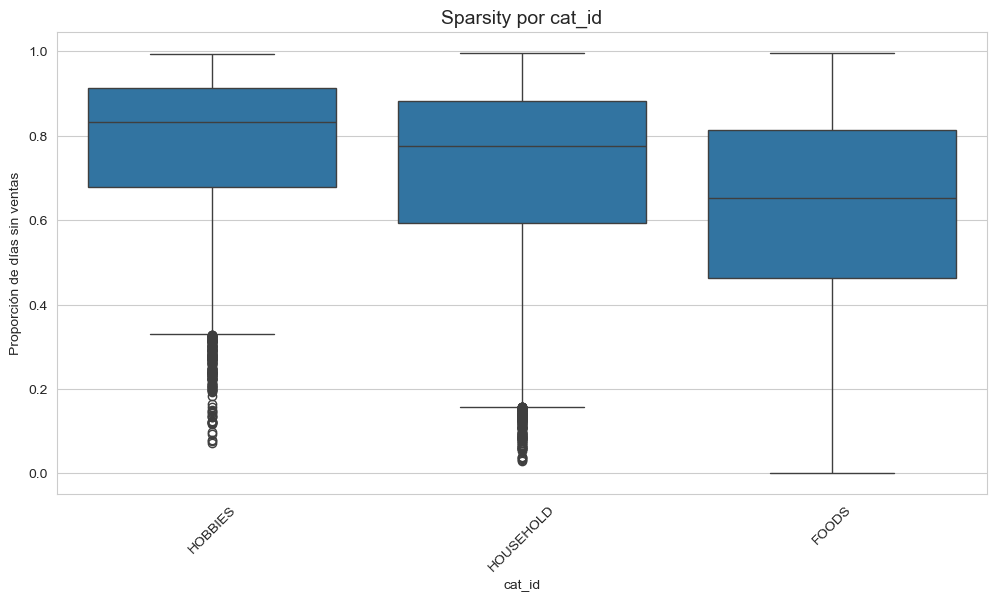

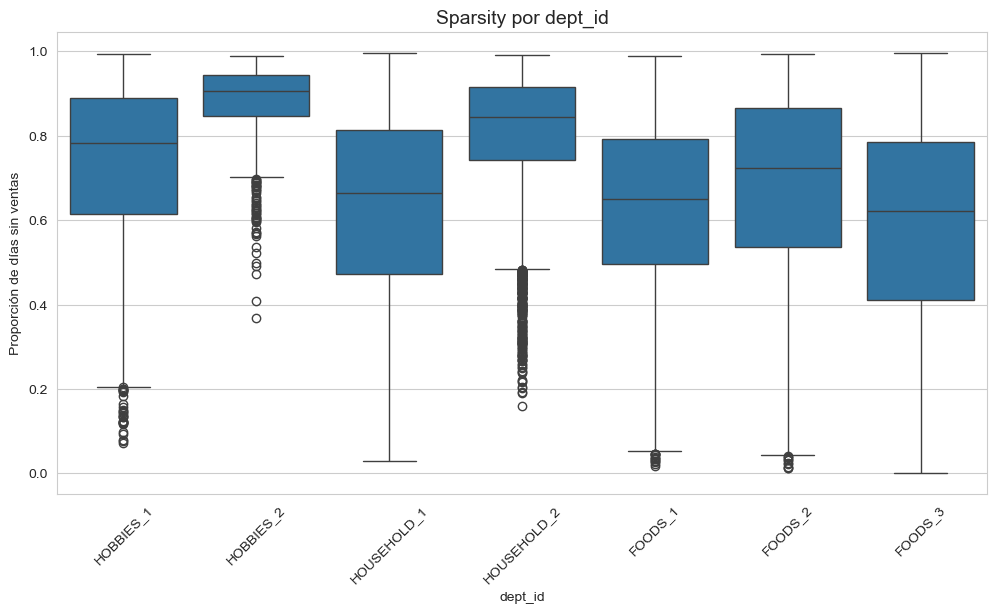

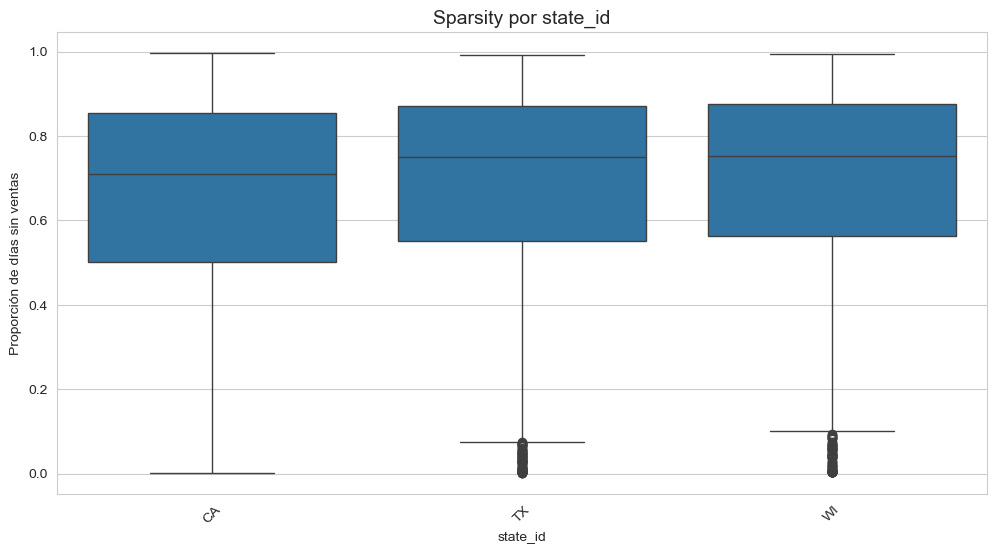

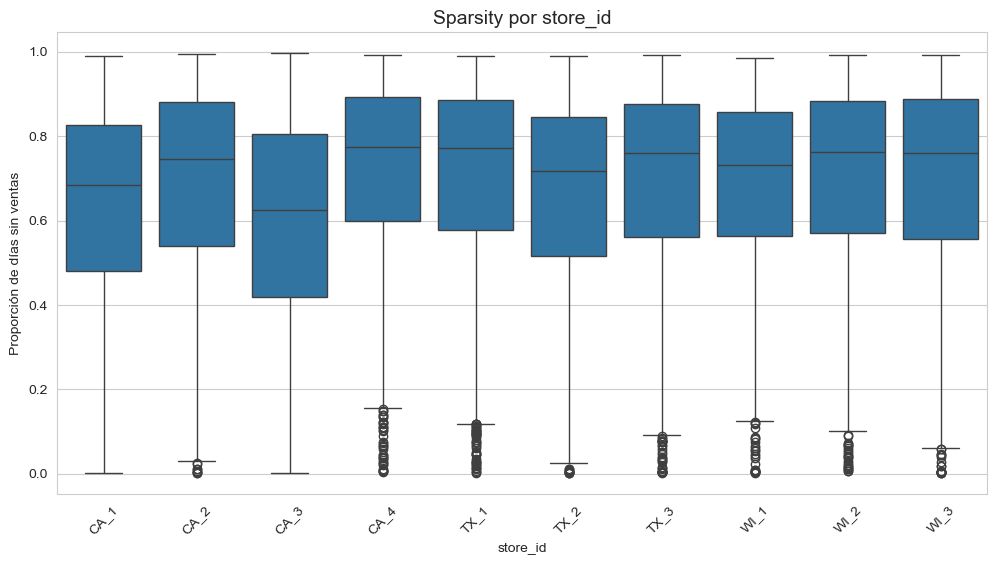

In [13]:
def boxplot_sparsity(df, category_col):
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=category_col, y="zero_ratio")
    plt.title(f"Sparsity por {category_col}", fontsize=14)
    plt.xlabel(category_col)
    plt.ylabel("Proporción de días sin ventas")
    plt.xticks(rotation=45)
    plt.show()

boxplot_sparsity(temp, "cat_id")
boxplot_sparsity(temp, "dept_id")
boxplot_sparsity(temp, "state_id")
boxplot_sparsity(temp, "store_id")


De los anteriores boxplot vemos que el conjunto de datos M5 presenta un alto porcentaje de días con ventas igual a cero, especialmente en productos de baja rotación. Esta característica influye en la calidad del modelamiento, ya que genera series dispersas y con largos tramos sin actividad, lo que puede afectar tanto la construcción de lags como el desempeño de los modelos y de las métricas de evaluación.

In [18]:
def analyze_zeros(df, id_cols):
    zero_report = (
        (df.drop(columns=id_cols) == 0)
        .mean(axis=1)
        .rename("pct_zeros")
    )
    return zero_report

id_cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

zero_report = analyze_zeros(sales_train_validation, id_cols)
print(zero_report.describe())
high_zero_series = sales_train_validation.loc[zero_report > 0.80, id_cols]
high_zero_series.head()

count    30490.000000
mean         0.681963
std          0.223773
min          0.001568
25%          0.536853
50%          0.735494
75%          0.867224
max          0.996341
Name: pct_zeros, dtype: float64


,id,item_id,dept_id,cat_id,store_id,state_id
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA
10,HOBBIES_1_011_CA_1_validation,HOBBIES_1_011,HOBBIES_1,HOBBIES,CA_1,CA
17,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA
23,HOBBIES_1_024_CA_1_validation,HOBBIES_1_024,HOBBIES_1,HOBBIES,CA_1,CA


El resumen estadístico del porcentaje de ceros en `sales_train_validation` indica que, en promedio, las series presentan alrededor de un **68% de días sin ventas**, con valores que van desde casos prácticamente activos hasta otros cercanos al **100%** de días con demanda nula. Esto confirma que el conjunto M5 incluye una proporción significativa de productos de baja o muy baja rotación, fenómeno característico del retail y propio de la denominada *long tail*.

Asimismo, se observa que el 75% de las series supera el 53% de ceros y que un grupo relevante de productos registra más del 80% de días sin ventas. En el ejemplo ilustrado, estas series pertenecen a la categoría **HOBBIES**, conocida por su comportamiento altamente esporádico. Este nivel de esparsidad tiene implicancias directas en el modelamiento, pues limita el rendimiento de métodos clásicos, condiciona la construcción de lags y afecta la estabilidad de métricas como RMSSE.

En conjunto, estos hallazgos anticipan desafíos importantes para el proceso de predicción y respaldan la necesidad de emplear técnicas y modelos capaces de manejar series altamente dispersas y con patrones de demanda poco regulares.

---
#### Porcentaje de días sin venta por categoría.

Luego de evaluar la proporción de ceros a nivel global, es útil desagregar este indicador por categoría (`cat_id`), ya que cada grupo de productos presenta comportamientos muy diferentes en términos de rotación y frecuencia de ventas. Categorías como *FOODS* suelen mostrar una demanda más estable y continua, mientras que *HOBBIES* y *HOUSEHOLD* tienden a exhibir mayor esporadicidad y un volumen más alto de días sin ventas.

El siguiente bloque incorpora el porcentaje de ceros a la información descriptiva de cada serie y calcula estadísticas resumidas por categoría, permitiendo comparar la dispersión y el nivel de esparsidad entre grupos de productos.


In [28]:
tmp = sales_train_validation[id_cols].copy()
tmp["pct_zeros"] = zero_report.values

category_summary = tmp.groupby("cat_id")["pct_zeros"].describe()
category_summary

,count,mean,std,min,25%,50%,75%,max
cat_id,,,,,,,,
FOODS,14370.0,0.620212,0.232450,0.001568,0.462624,0.652378,0.812859,0.994773
HOBBIES,5650.0,0.772801,0.182377,0.071093,0.679561,0.832462,0.913225,0.993204
HOUSEHOLD,10470.0,0.717696,0.206783,0.030319,0.592786,0.775745,0.882384,0.996341


Los resultados muestran diferencias claras entre las categorías del conjunto M5. **FOODS** presenta el porcentaje de ceros más bajo en promedio (≈0.62), lo cual es coherente con su alta rotación y demanda más constante. En contraste, **HOBBIES** exhibe el mayor nivel de esparsidad (≈0.77), reflejando ventas mucho más irregulares y esporádicas, propias de productos de baja demanda. **HOUSEHOLD** se sitúa en una posición intermedia (≈0.72), combinando artículos de consumo periódico con otros de baja frecuencia.

El amplio rango dentro de cada categoría(particularmente visible en los valores mínimo y máximo), confirma que existen tanto series muy activas como series casi completamente inactivas. Esta heterogeneidad afecta directamente la complejidad del modelamiento y justifica la necesidad de estrategias diferenciadas según categoría, así como modelos flexibles que manejen adecuadamente series con distintos niveles de esparsidad.


---
#### Porcentaje de días sin ventas por estado

Además de evaluar la esparsidad por categoría, es útil analizar cómo varía el porcentaje de ceros entre los distintos **estados** donde opera Walmart (CA, TX y WI). Este análisis permite identificar diferencias regionales en la dinámica de demanda, lo cual puede influir en la selección y calibración de modelos jerárquicos.

In [17]:
tmp = sales_train_validation[id_cols].copy()
tmp["pct_zeros"] = zero_report.values

state_summary = tmp.groupby("state_id")["pct_zeros"].describe()
state_summary

,count,mean,std,min,25%,50%,75%,max
state_id,,,,,,,,
CA,12196.0,0.662079,0.230563,0.001568,0.501830,0.709880,0.855724,0.996341
TX,9147.0,0.690723,0.222466,0.002091,0.552013,0.749608,0.870361,0.992682
WI,9147.0,0.699714,0.213627,0.003136,0.563513,0.751699,0.876634,0.993204


El resumen por *state_id* muestra que los tres estados presentan niveles elevados de esparsidad, con valores medios cercanos al 70% de días sin ventas. Aun así, se observan diferencias sistemáticas: California exhibe la menor proporción de ceros, mientras que Texas y Wisconsin presentan valores ligeramente superiores. Esto sugiere que la intensidad de la demanda varía por región, lo cual es relevante para el modelamiento jerárquico y para estrategias de segmentación basadas en comportamiento geográfico.

---
#### Porcentaje de días sin ventas por tienda

Tras el análisis por estado, un nivel de desagregación aún más detallado consiste en estudiar la esparsidad a nivel de **tienda**. Cada tienda presenta dinámicas propias de demanda, influenciadas por ubicación específica, tipo de clientela y estacionalidad local. Evaluar el porcentaje de ceros por *store_id* permite identificar tiendas con rotación particularmente baja o alta, lo que puede guiar decisiones sobre segmentación o modelamiento diferenciado.

In [18]:
store_summary = tmp.groupby("store_id")["pct_zeros"].describe()
store_summary

,count,mean,std,min,25%,50%,75%,max
store_id,,,,,,,,
CA_1,3049.0,0.639473,0.226160,0.003136,0.480397,0.685311,0.826451,0.990068
CA_2,3049.0,0.691085,0.221057,0.001568,0.539990,0.745426,0.880815,0.994773
CA_3,3049.0,0.596013,0.243059,0.002091,0.419237,0.625719,0.803973,0.996341
CA_4,3049.0,0.721746,0.210517,0.005227,0.598536,0.775222,0.893361,0.991636
TX_1,3049.0,0.708527,0.220036,0.002614,0.578150,0.771040,0.884475,0.990068
TX_2,3049.0,0.664612,0.224113,0.002091,0.516989,0.716153,0.846315,0.990591
TX_3,3049.0,0.699029,0.220896,0.003136,0.561422,0.760063,0.875588,0.992682
WI_1,3049.0,0.689984,0.205218,0.003136,0.562990,0.731312,0.856247,0.985886
WI_2,3049.0,0.707174,0.213755,0.005750,0.569786,0.761631,0.883429,0.992682


El resumen por *store_id* muestra diferencias apreciables en la esparsidad incluso dentro de un mismo estado. Algunas tiendas, como **CA_3**, presentan un porcentaje medio de ceros menor que el resto, lo que sugiere una rotación relativamente más alta. Otras, como **CA_4**, **TX_1** o varias tiendas de Wisconsin, exhiben valores medios por encima del 70%, reflejando una demanda más esporádica.

Estas variaciones a nivel de tienda confirman que la dinámica local influye de forma significativa en la frecuencia de ventas. Esto es relevante para el modelamiento, ya que puede justificar enfoques jerárquicos o modelos específicos por tienda en escenarios donde la estructura de demanda difiere sustancialmente entre establecimientos.

---
#### Porcentaje de ceros por categoría-**y**-estado.

Para identificar cómo interactúan la categoría del producto y la ubicación geográfica, se calcula el porcentaje medio de días sin ventas combinando **cat_id** y **state_id**. Este análisis permite detectar si ciertas categorías muestran una demanda más esporádica en algunos estados que en otros, revelando patrones regionales que podrían ser relevantes para la calibración de modelos jerárquicos y estrategias de segmentación.

In [19]:
cat_state = tmp.groupby(["cat_id", "state_id"])["pct_zeros"].mean()
cat_state

cat_id     state_id
FOODS      CA          0.603730
           TX          0.634669
           WI          0.627731
HOBBIES    CA          0.750831
           TX          0.780554
           WI          0.794341
HOUSEHOLD  CA          0.694270
           TX          0.719179
           WI          0.747446
Name: pct_zeros, dtype: float64

La combinación de *cat_id* y *state_id* muestra un patrón coherente con los análisis anteriores: las categorías **HOBBIES** y **HOUSEHOLD** presentan mayor esparsidad que **FOODS** en todos los estados. Además, se observa que Wisconsin tiende a exhibir los porcentajes más altos dentro de cada categoría, seguido de Texas y luego California. Esto indica que la demanda de ciertos grupos de productos es sistemáticamente más intermitente en algunos estados, lo que refuerza la importancia de considerar estructuras jerárquicas o modelos con componentes regionales al realizar las predicciones.

---
#### Porcentaje de ceros por departamento-**y**-estado.

Para obtener una visión más detallada dentro de cada categoría, se analiza ahora la esparsidad combinando **dept_id** (departamento) y **state_id** (estado). Esta desagregación permite identificar departamentos específicos cuya demanda es especialmente intermitente en ciertas regiones, proporcionando información más fina para segmentación, detección de patrones y diseño de modelos jerárquicos más precisos.

In [20]:
dept_state = tmp.groupby(["dept_id", "state_id"])["pct_zeros"].mean()
dept_state

dept_id      state_id
FOODS_1      CA          0.594065
             TX          0.669998
             WI          0.644515
FOODS_2      CA          0.691316
             TX          0.669910
             WI          0.677287
FOODS_3      CA          0.563910
             TX          0.608355
             WI          0.599361
HOBBIES_1    CA          0.703120
             TX          0.747813
             WI          0.756998
HOBBIES_2    CA          0.884037
             TX          0.871965
             WI          0.898600
HOUSEHOLD_1  CA          0.622206
             TX          0.622761
             WI          0.651220
HOUSEHOLD_2  CA          0.768713
             TX          0.818781
             WI          0.846849
Name: pct_zeros, dtype: float64

El desglose por `dept_id` dentro de cada estado revela patrones aún más específicos. Algunos departamentos, como **HOBBIES_2** y **HOUSEHOLD_2**, muestran porcentajes de ceros muy elevados en los tres estados, lo que indica una demanda altamente esporádica sin importar la región. En contraste, departamentos como **FOODS_1** y **FOODS_3** presentan niveles más bajos de esparsidad, reflejando una rotación más constante.

También se aprecia que Wisconsin tiende a concentrar los valores más altos dentro de varios departamentos, seguido de Texas, mientras que California mantiene los niveles más bajos en la mayoría de los casos. Este comportamiento sugiere que la demanda por departamento no solo depende del tipo de producto, sino también de dinámicas regionales específicas, lo que puede influir en estrategias de modelamiento y decisiones operativas basadas en la granularidad del departamento.


---
## Detección de rupturas estructurales en la serie de ventas

Además de los ceros y de la variabilidad diaria, es importante identificar cambios persistentes en el comportamiento de la serie de tiempo, conocidos como *rupturas estructurales* o *structural breaks*. Estos quiebres pueden reflejar modificaciones sostenidas en el nivel de ventas, cambios en la tendencia, alteraciones en la estacionalidad o eventos significativos que afectan de manera permanente la dinámica de la demanda.

La presencia de rupturas tiene implicancias directas en el modelamiento, ya que influye en la estabilidad de los modelos, en la construcción de ventanas para validación temporal y en la correcta especificación de lags. Para detectarlas de manera automática, se emplea el método **PELT (Pruned Exact Linear Time)** de la librería `ruptures`, que permite identificar puntos de cambio en secuencias numéricas de forma eficiente, incluso en series extensas como las del dataset M5.

El siguiente bloque define una función que aplica este método a cualquier serie individual, retornando los índices donde el algoritmo identifica rupturas persistentes.

In [20]:
def detect_breaks(series, model="rbf", pen=10):
    signal = series.values
    algo = rpt.Pelt(model=model).fit(signal)
    break_points = algo.predict(pen=pen)
    return break_points[:-1] 


Una vez definida la función encargada de identificar quiebres estructurales mediante el algoritmo PELT, es necesario aplicarla a una serie concreta para ejemplificar su uso y analizar los cambios relevantes en el comportamiento de la demanda. En este caso, se selecciona una fila específica del conjunto `sales_train_validation`, correspondiente a un único producto en una tienda determinada, y se extraen sus valores diarios de ventas.

El objetivo es determinar si esta serie presenta cambios persistentes que puedan afectar su modelamiento posterior. Para ello, se transforma la serie a tipo numérico `float` (requisito de la librería `ruptures`) y se ejecuta la función de detección, obteniendo los índices donde ocurren posibles rupturas.


In [29]:
series = sales_train_validation.iloc[2, 6:].astype(float)
breaks = detect_breaks(series)
print("Rupturas detectadas:", breaks)

Rupturas detectadas: [1440]


El algoritmo PELT identificó una ruptura estructural en el índice 1440 de la serie, lo que indica un cambio persistente en el comportamiento de la demanda a partir de ese punto. Este tipo de quiebre suele asociarse a modificaciones sostenidas en el nivel de ventas, variaciones en la tendencia, aparición o desaparición de estacionalidad o un evento que altera permanentemente la dinámica del producto.

La presencia de esta ruptura es consistente con la naturaleza de muchas series del dataset M5, especialmente en categorías de baja rotación como *HOBBIES*, donde la demanda puede cambiar abruptamente debido a disponibilidad de inventario, introducción de promociones, cambios en catálogo o comportamiento irregular de los consumidores. Este hallazgo debe considerarse al definir el esquema de validación temporal y al seleccionar modelos, ya que la existencia de cambios estructurales puede afectar la estabilidad del pronóstico y justificar el uso de ventanas recientes o estrategias robustas de entrenamiento.

---
## Construcción del DataFrame temporal para análisis de patrones

Para estudiar los patrones temporales de una serie individual como la estacionalidad semanal, mensual o los cambios en tendencia, es necesario combinar la información de ventas con las variables del calendario. Con este propósito se crea un DataFrame temporal que contiene la serie diaria seleccionada y sus fechas correspondientes, permitiendo así calcular atributos relevantes como el día de la semana, el mes o el año.

Esta integración es fundamental para revelar comportamientos regulares o estacionales que no son evidentes en la serie original y para justificar la inclusión de variables exógenas (por ejemplo, `dow`, `month`) en la etapa de ingeniería de características. El siguiente bloque construye dicho DataFrame y agrega las columnas necesarias para el análisis exploratorio.


In [ ]:
series = sales_train_validation.iloc[2, 6:].astype(float)
df_tmp = pd.DataFrame({"sales": series.values})

df_tmp["date"] = calendar["date"][:len(df_tmp)]
df_tmp["date"] = pd.to_datetime(df_tmp["date"])

df_tmp.set_index("date", inplace=True)

df_tmp["dow"] = df_tmp.index.dayofweek
df_tmp["month"] = df_tmp.index.month
df_tmp["year"] = df_tmp.index.year

---
### Análisis del Comportamiento Semanal

Para identificar estacionalidad semanal, se agrupan las ventas según el día de la semana (`dow`) y se calcula el promedio correspondiente. Esto permite observar si existen patrones regulares, como mayor o menor demanda en determinados días.

In [22]:
df_tmp.groupby("dow")["sales"].mean()

dow
0    0.106227
1    0.117216
2    0.117216
3    0.131868
4    0.172161
5    0.248175
6    0.160584
Name: sales, dtype: float64

Para observar de forma más clara cómo varía la demanda según el día de la semana, se grafica el promedio de ventas por `dow` en un diagrama de barras. Esto permite identificar rápidamente qué días concentran mayor o menor actividad.


<Axes: xlabel='dow'>

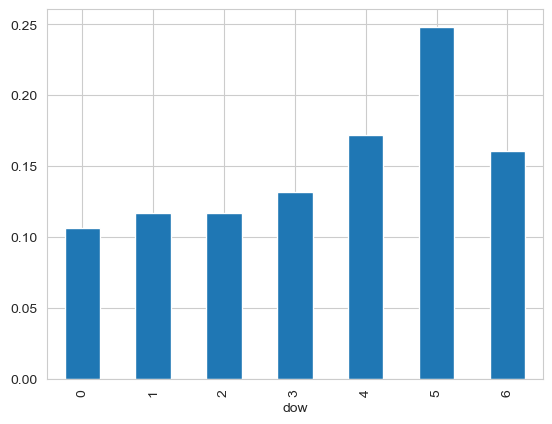

In [23]:
df_tmp.groupby("dow")["sales"].mean().plot(kind="bar")

El promedio por día de la semana muestra diferencias claras en el nivel de ventas. La demanda es más baja entre lunes y miércoles y aumenta progresivamente hacia el fin de semana, alcanzando su máximo el día sábado. Este comportamiento sugiere la presencia de una estacionalidad semanal consistente, útil para justificar la incorporación de variables como `dow` o indicadores de fin de semana en la etapa de modelamiento.

---
### Suavizamiento de la serie mediante media móvil

Para identificar tendencias generales y reducir el ruido diario propio de series con alta variabilidad, se aplica una media móvil de 30 días. Esta transformación permite visualizar cambios persistentes en el nivel de ventas y detectar variaciones que no son evidentes en la serie original.


<Axes: xlabel='date'>

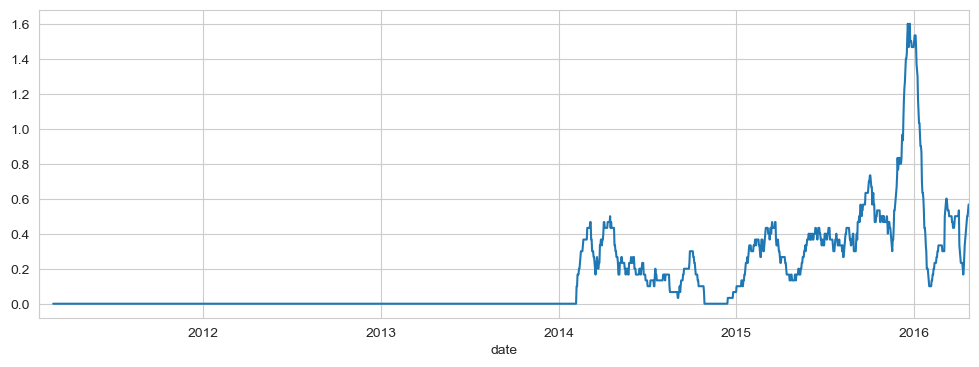

In [24]:
df_tmp["sales"].rolling(30).mean().plot(figsize=(12,4))

La media móvil de 30 días revela un comportamiento mucho más claro de la tendencia subyacente. La serie muestra un largo periodo inicial sin actividad, seguido de un aumento sostenido a partir de 2014 y un pico marcado hacia finales de 2015. Este patrón confirma la presencia de cambios estructurales en la demanda y una evolución irregular típica de productos de baja rotación, donde los valores diarios presentan gran variabilidad pero la media móvil permite identificar fases de crecimiento y caída de manera más estable.

---
### Análisis del Comportamiento Mensual

Para identificar posibles patrones estacionales a nivel mensual, se agrupan las ventas según el mes del año y se calcula su promedio. Esto permite observar si ciertos meses presentan mayor o menor demanda.

In [25]:
df_tmp.groupby("month")["sales"].mean()

month
1     0.101266
2     0.176471
3     0.198925
4     0.160920
5     0.129032
6     0.093333
7     0.090323
8     0.090323
9     0.193333
10    0.103226
11    0.153333
12    0.303226
Name: sales, dtype: float64

Se grafica el promedio de ventas por mes en un diagrama de barras para observar de manera clara si existen meses con mayor actividad o estacionalidad marcada en la serie.


<Axes: xlabel='month'>

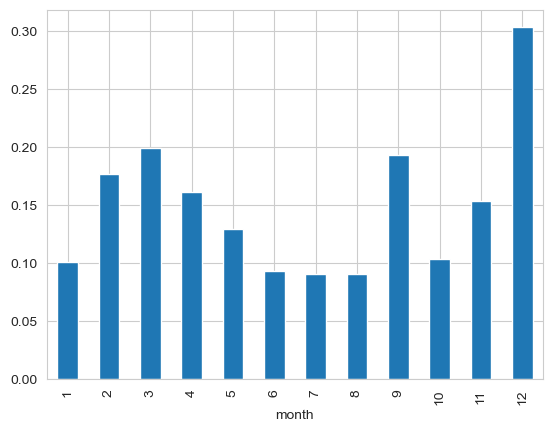

In [26]:
df_tmp.groupby("month")["sales"].mean().plot(kind="bar")

El promedio mensual revela una estacionalidad marcada, con valores más bajos entre junio y agosto y un aumento notable en diciembre, mes que concentra la mayor demanda. También se observan incrementos secundarios en marzo y septiembre. Este comportamiento sugiere que la serie presenta estacionalidad anual moderada, con picos asociados a periodos de mayor actividad comercial, especialmente hacia fin de año.

---
### Cálculo de la correlación entre ventas y precio

Para evaluar si las variaciones de precio tienen relación con los cambios en la demanda del producto, se construye un conjunto de datos que combina la serie de ventas del ítem seleccionado con su información de precios semanales. Esto requiere unir la serie diaria con el identificador de semana (`wm_yr_wk`) del calendario y luego mapear el precio correspondiente desde la tabla `sell_prices`. Una vez integrados ambos elementos, se calcula la correlación entre ventas y precio con el fin de identificar posibles efectos de elasticidad o estabilidad en el comportamiento del producto.

**Selección de la serie**

In [38]:
idx_seleccionado = 2
row = sales_train_validation.iloc[idx_seleccionado]

item_id = row["item_id"]
store_id = row["store_id"]

print(f"Analizando: {item_id} en tienda {store_id}")

sales_series = row[6:].astype(float).reset_index(drop=True)

sales_df = pd.DataFrame({"sales": sales_series})

display(sales_df.head())

Analizando: HOBBIES_1_003 en tienda CA_1


,sales
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


**Incorporación de la Dimensión Temporal**

In [39]:
sales_df["date"] = pd.to_datetime(calendar["date"][:len(sales_df)])

sales_df.set_index("date", inplace=True)

sales_df["wm_yr_wk"] = calendar["wm_yr_wk"][:len(sales_df)].values

print("Datos con fechas y semanas:")
display(sales_df.head())

Datos con fechas y semanas:


,sales,wm_yr_wk
date,,
2011-01-29,0.0,11101
2011-01-30,0.0,11101
2011-01-31,0.0,11101
2011-02-01,0.0,11101
2011-02-02,0.0,11101


**Integración de Precios**

In [40]:
prices_subset = sell_prices[
    (sell_prices["item_id"] == item_id) &
    (sell_prices["store_id"] == store_id)
]

sales_df = sales_df.merge(
    prices_subset[["wm_yr_wk", "sell_price"]],
    on="wm_yr_wk",
    how="left"
)

if "date" in sales_df.columns:
    sales_df.set_index("date", inplace=True)

sales_df.drop(columns=["wm_yr_wk"], inplace=True, errors='ignore')

print("Dataset final integrado (Ventas + Precios):")
display(sales_df.head())

Dataset final integrado (Ventas + Precios):


,sales,sell_price
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN


**Análisis de Correlación (Pearson)**

Producto: HOBBIES_1_003
Correlación ventas vs precio: -0.0000


<Axes: title={'center': 'Ventas y Precio: HOBBIES_1_003'}>

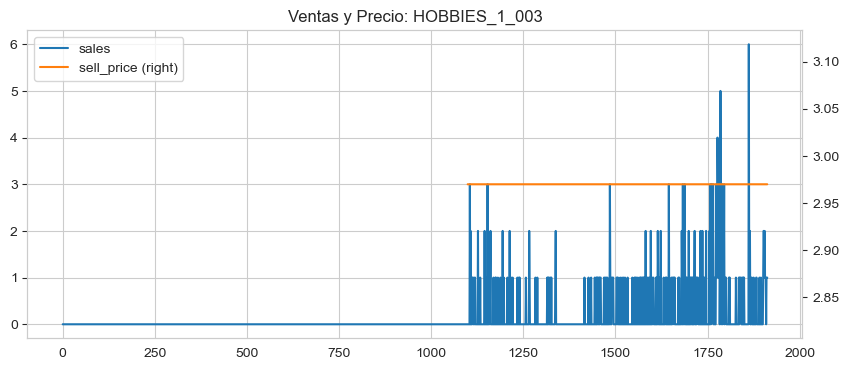

In [41]:
corr_price = sales_df["sales"].corr(sales_df["sell_price"])

print(f"Producto: {item_id}")
print(f"Correlación ventas vs precio: {corr_price:.4f}")

sales_df.plot(secondary_y="sell_price", figsize=(10, 4), title=f"Ventas y Precio: {item_id}")

Notemos que, por la línea naranja del gráfico, el precio nunca cambió, así, no existe correlación entre ambas variables (correlación entre una variable y una constante siempre es cero). La correlación no es informativa, y se requiere revisar la disponibilidad y variabilidad del precio antes de interpretar cualquier relación entre ambas variables.

---
### Correlación entre ventas y beneficios SNAP

Para evaluar si los días en que se activa el beneficio SNAP (programa de asistencia alimentaria en EE.UU.) influyen en el comportamiento de la demanda, se incorpora la variable correspondiente según el estado de la serie analizada. Esto permite medir la relación entre ventas y la señal SNAP mediante una correlación simple, identificando posibles aumentos de demanda asociados a días con subsidios.

In [ ]:
state = sales_train_validation.iloc[2]["state_id"]

snap_col = f"snap_{state}"

sales_df["snap"] = calendar[snap_col].iloc[:len(sales_df)].values

print("Correlación ventas vs SNAP:")
print(sales_df[["sales", "snap"]].corr())



📌 Correlación ventas vs SNAP:
          sales      snap
sales  1.000000 -0.008794
snap  -0.008794  1.000000


La correlación entre ventas y la variable SNAP es cercana a cero (aprox. −0.009), lo que indica que, para esta serie específica, **los días con beneficio SNAP no muestran una relación lineal significativa con el nivel de ventas**. En términos prácticos, esto sugiere que la activación del subsidio no altera de manera sistemática la demanda del producto analizado. Sin embargo, este resultado puede variar según el tipo de artículo, la tienda o la categoría, por lo que conviene repetir el análisis en otros segmentos antes de extraer conclusiones generales.

---
### Correlación entre series de la misma categoría

Para evaluar si los productos de una misma categoría presentan patrones de demanda similares entre distintas tiendas, se seleccionan varias series pertenecientes a la misma categoría y se calcula la matriz de correlación entre ellas. Este análisis permite identificar si existen comportamientos compartidos —por ejemplo, respuestas similares a estacionalidad o eventos locales— que podrían aprovecharse en modelos multivariados o en enfoques de agrupamiento.

In [ ]:
cat = sales_train_validation.iloc[2]["cat_id"]

same_cat = sales_train_validation[sales_train_validation["cat_id"] == cat]

n = 5
subset = same_cat.iloc[:n, 6:].astype(float).T
subset.columns = same_cat.iloc[:n]["store_id"].values

print("Correlación entre tiendas (misma categoría):")
subset.corr()



 Correlación entre tiendas (misma categoría):


,CA_1,CA_1,CA_1,CA_1,CA_1
CA_1,1.000000,0.043393,0.173605,0.188614,0.050161
CA_1,0.043393,1.000000,0.093971,0.005377,0.137294
CA_1,0.173605,0.093971,1.000000,0.049156,0.061977
CA_1,0.188614,0.005377,0.049156,1.000000,0.088325
CA_1,0.050161,0.137294,0.061977,0.088325,1.000000


Los valores de correlación observados entre las series de la misma categoría muestran **relaciones lineales muy débiles** entre tiendas. Esto sugiere que, incluso dentro de una misma categoría de productos, el comportamiento de la demanda puede ser **altamente específico a cada tienda**, quizás influido por factores locales como composición del público, inventario disponible o patrones particulares de compra.

En la práctica, estas correlaciones bajas indican que **modelos multivariados entre tiendas no aportarían gran beneficio** para esta categoría específica, y que es más adecuado tratar cada serie de forma independiente o aplicar métodos que manejen bien la heterogeneidad entre unidades.

---
---
# Visualización

In [ ]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

## Analizaremos la tendencia globan el ventas

In [ ]:
total_sales = sales_train_validation.iloc[:, 6:].sum().T

total_sales.index = pd.to_datetime(calendar['date'][:1913])

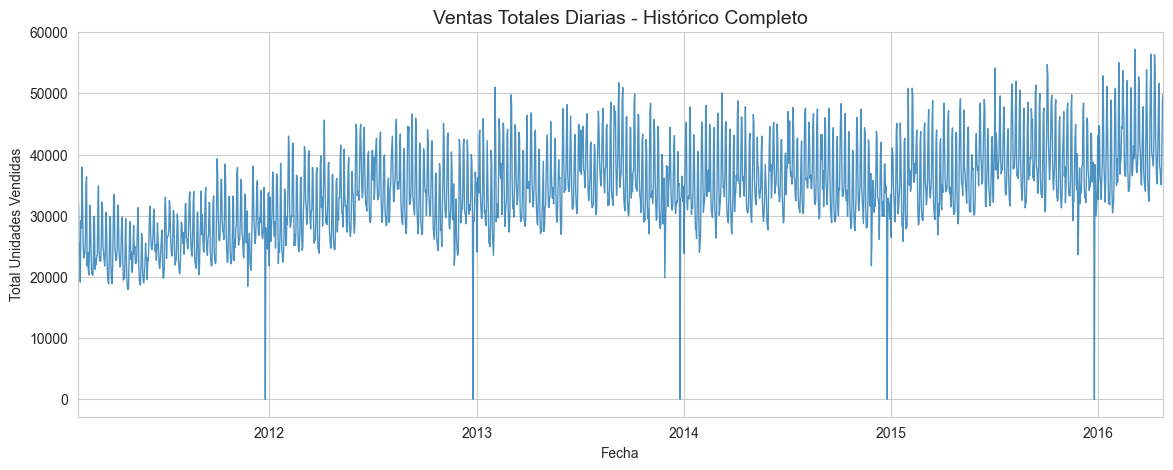

In [35]:
plt.figure()
total_sales.plot(color='#1f77b4', alpha=0.8, linewidth=1)
plt.title("Ventas Totales Diarias - Histórico Completo", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Total Unidades Vendidas")
plt.show()

---
### Estacionalidad (Día de la semana y Mes)

In [ ]:
df_plot = pd.DataFrame({'ventas': total_sales.values, 'date': total_sales.index})
df_plot['dia_sem'] = df_plot['date'].dt.day_name()
df_plot['mes'] = df_plot['date'].dt.month_name()

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\29843265.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dia_sem', y='ventas', data=df_plot, order=dias_orden, ax=axes[0], palette="viridis")
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\29843265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mes', y='ventas', data=df_plot, order=meses_orden, ax=axes[1], palette="coolwarm")


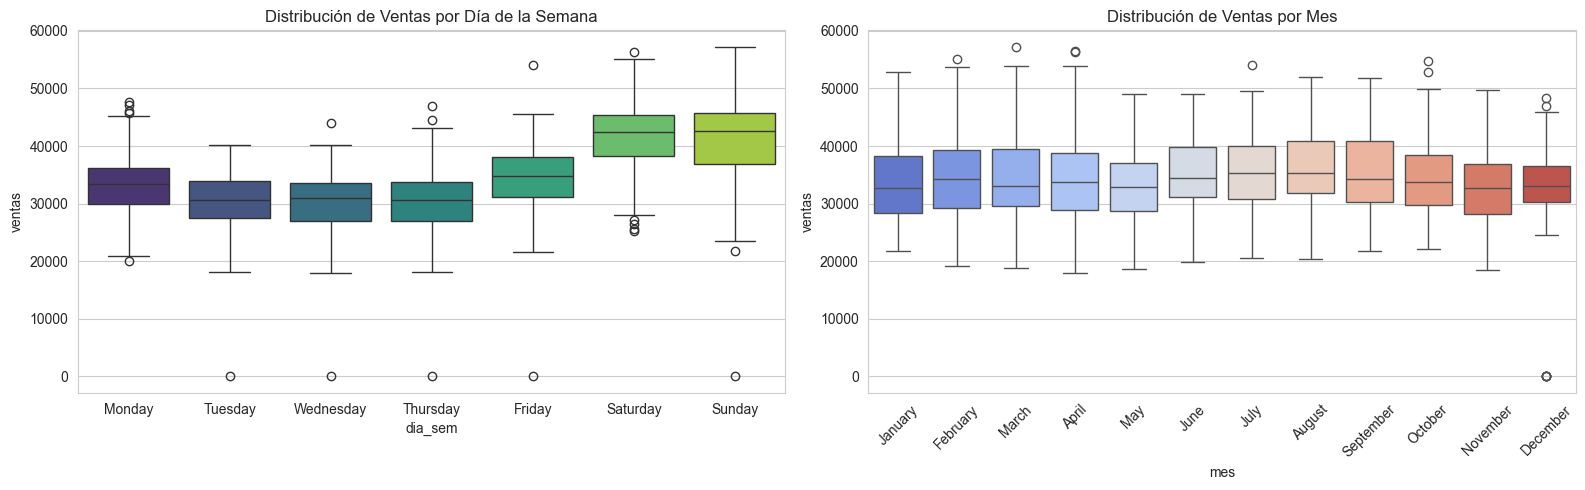

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(x='dia_sem', y='ventas', data=df_plot, order=dias_orden, ax=axes[0], palette="viridis")
axes[0].set_title("Distribución de Ventas por Día de la Semana")

meses_orden = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
sns.boxplot(x='mes', y='ventas', data=df_plot, order=meses_orden, ax=axes[1], palette="coolwarm")
axes[1].set_title("Distribución de Ventas por Mes")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
### Análisis de Intermitencia

In [ ]:
porcentaje_ceros = (sales_train_validation.iloc[:, 6:] == 0).mean(axis=1)

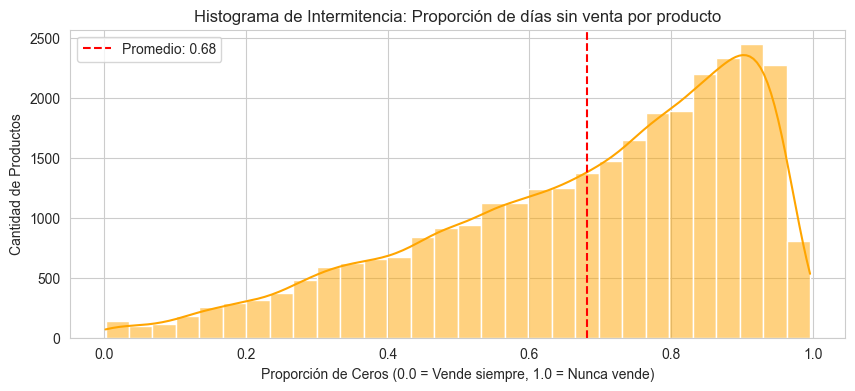

In [39]:
plt.figure(figsize=(10, 4))
sns.histplot(porcentaje_ceros, bins=30, color='orange', kde=True)

plt.title("Histograma de Intermitencia: Proporción de días sin venta por producto")
plt.xlabel("Proporción de Ceros (0.0 = Vende siempre, 1.0 = Nunca vende)")
plt.ylabel("Cantidad de Productos")
plt.axvline(porcentaje_ceros.mean(), color='red', linestyle='--', label=f'Promedio: {porcentaje_ceros.mean():.2f}')

plt.legend()
plt.show()

---
---
# Preprocesamiento

## Optimizamos SALES_TRAIN_VALIDATION

In [ ]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

for col in id_cols:
    sales_train_validation[col] = sales_train_validation[col].astype('category')

In [ ]:
d_cols = [c for c in sales_train_validation.columns if 'd_' in c]
sales_train_validation[d_cols] = sales_train_validation[d_cols].astype('int16')

## Optimizamos CALENDAR

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['d_int'] = calendar['d'].apply(lambda x: int(x.split('_')[1])).astype('int16')

In [45]:
# Reducimos el peso de columnas numéricas
for col in ['wm_yr_wk', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']:
    if col in calendar.columns:
        calendar[col] = calendar[col].astype('int16')

## Optimizamos SELL_PRICES

In [ ]:
sell_prices['sell_price'] = sell_prices['sell_price'].astype('float16')
sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype('int16')
sell_prices['store_id'] = sell_prices['store_id'].astype('category')
sell_prices['item_id'] = sell_prices['item_id'].astype('category')
gc.collect() 

11272

### Transformamos datos a formato largo

In [47]:
data = pd.melt(sales_train_validation, 
               id_vars=id_cols, 
               var_name='d', 
               value_name='ventas')

In [ ]:
data['d'] = data['d'].apply(lambda x: int(x.split('_')[1])).astype('int16')

In [ ]:
del sales_train_validation
gc.collect()

4593

In [ ]:
print(f"Filas generadas: {len(data)}")

   Filas generadas: 58327370


### Hacemos un merge entre los datos

In [ ]:
cols_cal = ['d_int', 'wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'snap_CA', 'snap_TX', 'snap_WI']

In [ ]:
cols_cal = [c for c in cols_cal if c in calendar.columns]

In [ ]:
data = data.merge(calendar[cols_cal], left_on='d', right_on='d_int', how='left')
data.drop(columns=['d_int'], inplace=True)

In [ ]:
data = data.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [ ]:
del calendar, sell_prices
gc.collect()

0

---
## Feature Engineering

**Ordenamos para que los cálculos temporales sean correctos**

In [ ]:
data.sort_values(['id', 'd'], inplace=True)

In [ ]:
data['lag_28'] = data.groupby('id')['ventas'].transform(lambda x: x.shift(28)).astype('float16')

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\971647755.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['lag_28'] = data.groupby('id')['ventas'].transform(lambda x: x.shift(28)).astype('float16')


In [ ]:
data['rolling_mean_7'] = data.groupby('id')['lag_28'].transform(lambda x: x.rolling(7).mean()).astype('float16')
data['rolling_mean_28'] = data.groupby('id')['lag_28'].transform(lambda x: x.rolling(28).mean()).astype('float16')

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\769694564.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['rolling_mean_7'] = data.groupby('id')['lag_28'].transform(lambda x: x.rolling(7).mean()).astype('float16')
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\769694564.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['rolling_mean_28'] = data.groupby('id')['lag_28'].transform(lambda x: x.rolling(28).mean()).astype('float16')


---
### Hacemos una limpieza final de datos

In [ ]:
if 'snap_CA' in data.columns:
    data['snap'] = np.where(data['state_id'] == 'CA', data['snap_CA'], 
                   np.where(data['state_id'] == 'TX', data['snap_TX'], data['snap_WI'])).astype('int8')
    data.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'], inplace=True)
data = data.dropna()

In [ ]:
cat_feats = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1']
for col in cat_feats:
    if col in data.columns:
        if data[col].dtype.name == 'category':
            if 'Unknown' not in data[col].cat.categories:
                data[col] = data[col].cat.add_categories('Unknown')
            data[col] = data[col].fillna('Unknown')
        else:
            data[col] = data[col].fillna('Unknown')
            
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str)).astype('int16')

In [61]:
print(f"Dimensiones finales del dataset: {data.shape}")
print(data.info())
gc.collect()

Dimensiones finales del dataset: (45327782, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 45327782 entries, 1678562 to 58325932
Data columns (total 18 columns):
 #   Column           Dtype   
---  ------           -----   
 0   id               category
 1   item_id          int16   
 2   dept_id          int16   
 3   cat_id           int16   
 4   store_id         int16   
 5   state_id         int16   
 6   d                int16   
 7   ventas           int16   
 8   wm_yr_wk         int16   
 9   wday             int16   
 10  month            int16   
 11  year             int16   
 12  event_name_1     int16   
 13  sell_price       float16 
 14  lag_28           float16 
 15  rolling_mean_7   float16 
 16  rolling_mean_28  float16 
 17  snap             int8    
dtypes: category(1), float16(4), int16(12), int8(1)
memory usage: 1.8 GB
None


0

---
---
# Modelamiento

En esta etapa definimos formalmente el problema predictivo: la **variable
objetivo** es `ventas` (demanda diaria por serie `id`), y las **features** provienen
de calendario, precios e ingeniería de lags/rolling generada en el
preprocesamiento.

Para mantener el notebook ejecutable, trabajamos con un **subconjunto
representativo de series**, preservando la estructura original del dataset.

La evaluación se realiza mediante **validación walk-forward**, respetando la
causalidad temporal, y reportando posteriormente **RMSSE**, **RMSE** y **MAE**.

Los modelos Empleados son:

- Naive  
- SNaive estacional  
- SARIMA (serie agregada)  
- Regresión Lineal con lags  
- LightGBM  
- Prophet con regresores

El objetivo de esta sección es estimar cada modelo, generar predicciones en
cada split temporal y almacenar los resultados para su posterior evaluación.

In [ ]:
if 'd_int' not in data.columns:
    data['d_int'] = data['d'].astype('int32')

if 'sell_price' not in data.columns:
    data['sell_price'] = 0.0
if 'snap' not in data.columns:
    data['snap'] = 0

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmsse_m5(data_train, data_val, y_pred,
             id_col='id', target_col='ventas'):

    denoms = {}
    for serie_id, g in data_train.groupby(id_col):
        serie = g[target_col].values
        diff = np.diff(serie)
        if len(diff) == 0:
            denoms[serie_id] = 1e-6
        else:
            denom = np.mean(diff**2)
            if denom == 0:
                denom = 1e-6
            denoms[serie_id] = denom

    df_val = data_val[[id_col, target_col]].copy()
    df_val["y_pred"] = y_pred

    vals = []
    for serie_id, g in df_val.groupby(id_col):
        if serie_id not in denoms:
            continue
        num = np.mean((g[target_col].values - g["y_pred"].values)**2)
        vals.append(np.sqrt(num / denoms[serie_id]))

    return np.mean(vals) if len(vals) > 0 else np.nan



In [ ]:
def generar_splits_walk_forward(df, n_splits=3, horizon=28):

    dias = np.sort(df['d_int'].unique())
    splits = []
    for i in range(n_splits):
        val_start_idx = len(dias) - (i + 1) * horizon
        val_end_idx   = len(dias) - i * horizon
        if val_start_idx <= 0:
            continue
        train_days = dias[:val_start_idx]
        val_days   = dias[val_start_idx:val_end_idx]
        splits.append((train_days, val_days))
    splits = splits[::-1]

    print("Splits (train_end, val_ini, val_fin):")
    for tr, va in splits:
        print(int(tr[-1]), int(va[0]), int(va[-1]))
    return splits



In [ ]:
def evaluar_modelo_walk_forward(nombre_modelo, fit_predict_fn,
                                data_full, feature_cols, splits):
    registros = []
    for i, (train_days, val_days) in enumerate(splits, start=1):
        df_train = data_full[data_full['d_int'].isin(train_days)].copy()
        df_val   = data_full[data_full['d_int'].isin(val_days)].copy()

        X_train = df_train[feature_cols]
        y_train = df_train[target_col].values
        X_val   = df_val[feature_cols]
        y_val   = df_val[target_col].values

        y_pred = fit_predict_fn(X_train, y_train, X_val, df_train, df_val)

        registros.append({
            "modelo": nombre_modelo,
            "split": i,
            "RMSE": rmse(y_val, y_pred),
            "MAE": mae(y_val, y_pred),
            "RMSSE": rmsse_m5(df_train, df_val, y_pred)
        })
    return pd.DataFrame(registros)

In [ ]:
data_model = data.copy()

target_col = "ventas"

numeric_cols = data_model.select_dtypes(include=[np.number]).columns.tolist()

cols_excluir = [target_col, 'd_int']

feature_cols = [c for c in numeric_cols if c not in cols_excluir]

print("Filas en data_model:", len(data_model))
print("Nº de features:", len(feature_cols))
print("Algunas features:", feature_cols[:15])

splits = generar_splits_walk_forward(data_model, n_splits=3, horizon=28)


Filas en data_model: 45327782
Nº de features: 16
Algunas features: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'wm_yr_wk', 'wday', 'month', 'year', 'event_name_1', 'sell_price', 'lag_28', 'rolling_mean_7', 'rolling_mean_28']
Splits (train_end, val_ini, val_fin):
1829 1830 1857
1857 1858 1885
1885 1886 1913


---
### Modelo Naive

In [ ]:
def fit_predict_naive(X_train, y_train, X_val, df_train, df_val):

    last_vals = df_train.groupby('id')[target_col].last().to_dict()
    
    y_pred = df_val['id'].map(last_vals).values.astype('float32')

    y_pred = np.nan_to_num(y_pred, nan=0.0)

    return y_pred

result_naive = evaluar_modelo_walk_forward(
    "Naive", fit_predict_naive, data_model, feature_cols, splits)

display(result_naive)


C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1921457490.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last_vals = df_train.groupby('id')[target_col].last().to_dict()
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in data_train.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 

,modelo,split,RMSE,MAE,RMSSE
0,Naive,1,3.137658,1.380798,NaN
1,Naive,2,3.140097,1.392495,NaN
2,Naive,3,3.300666,1.350344,NaN


---
### Modelo SNaive (estacionalidad semanal)

In [75]:
def fit_predict_snaive(X_train, y_train, X_val, df_train, df_val, periodo=7):
    
    hist = df_train.set_index(['id', 'd_int'])[target_col]
    preds = []

    for _, row in df_val[['id', 'd_int']].iterrows():
        key_lag = (row['id'], row['d_int'] - periodo)

        if key_lag in hist.index:
            preds.append(hist.loc[key_lag])

        else:
            preds.append(0.0)

    return np.array(preds, dtype='float32')

result_snaive = evaluar_modelo_walk_forward(
    "SNaive_7",
    lambda Xtr, ytr, Xv, dtr, dv: fit_predict_snaive(Xtr, ytr, Xv, dtr, dv, periodo=7),
    data_model, feature_cols, splits)

display(result_snaive)


C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in data_train.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in df_val.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:35: RuntimeWarning: invalid value encountered in sqrt
  vals.append(np.sqrt(num / denoms[serie_id]))
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and wi

,modelo,split,RMSE,MAE,RMSSE
0,SNaive_7,1,3.676335,1.325087,NaN
1,SNaive_7,2,3.632498,1.320374,NaN
2,SNaive_7,3,3.606007,1.345514,NaN


---
### Regresión Lineal

In [76]:
pipe_lr = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LinearRegression())
])

def fit_predict_linear(X_train, y_train, X_val, df_train, df_val):
    model = pipe_lr.fit(X_train, y_train)
    return model.predict(X_val).astype('float32')

result_lr = evaluar_modelo_walk_forward(
    "LinearRegression", fit_predict_linear, data_model, feature_cols, splits
)

display(result_lr)

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in data_train.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in df_val.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:35: RuntimeWarning: invalid value encountered in sqrt
  vals.append(np.sqrt(num / denoms[serie_id]))
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and wi

,modelo,split,RMSE,MAE,RMSSE
0,LinearRegression,1,2.452467,1.099103,NaN
1,LinearRegression,2,2.353560,1.105754,NaN
2,LinearRegression,3,2.242696,1.090929,NaN


---
### LightGBM (Gradient Boosting)

In [ ]:
data_lgbm = data_model.sample(
    n=250_000,      
    random_state=42
).copy()

print("Filas en data_lgbm:", len(data_lgbm))

splits_lgbm = generar_splits_walk_forward(
    data_lgbm,
    n_splits=3,
    horizon=28
)

Filas en data_lgbm: 250000
Splits (train_end, val_ini, val_fin):
1829 1830 1857
1857 1858 1885
1885 1886 1913
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1684
[LightGBM] [Info] Number of data points in the train set: 235803, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1060 3GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (3.60 MB) transferred to GPU in 0.008424 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.426971


C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in data_train.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in df_val.groupby(id_col):
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: Runt

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1685
[LightGBM] [Info] Number of data points in the train set: 240475, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1060 3GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (3.67 MB) transferred to GPU in 0.006918 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.426668


C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in data_train.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in df_val.groupby(id_col):
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: Runt

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1685
[LightGBM] [Info] Number of data points in the train set: 245133, number of used features: 16
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1060 3GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (3.74 MB) transferred to GPU in 0.006677 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1.425279


C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in data_train.groupby(id_col):
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\1751490600.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for serie_id, g in df_val.groupby(id_col):
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: Runt

,modelo,split,RMSE,MAE,RMSSE
0,LightGBM,1,2.782938,1.177645,NaN
1,LightGBM,2,2.205178,1.112740,NaN
2,LightGBM,3,2.138114,1.086465,NaN


In [ ]:
def fit_predict_lgbm(X_train, y_train, X_val, df_train, df_val):
    params = {
        "n_estimators": 500,
    "learning_rate": 0.05,
    "num_leaves": 63,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "device": "gpu",          
    "gpu_platform_id": 0,      
    "gpu_device_id": 0
    }
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, df_val[target_col].values)],
        eval_metric="rmse"
    )
    
    return model.predict(X_val).astype('float32')

result_lgbm = evaluar_modelo_walk_forward(
    "LightGBM",
    fit_predict_lgbm,
    data_lgbm,
    feature_cols,
    splits_lgbm
)

display(result_lgbm)

Para garantizar reproducibilidad, tiempo computacional razonable y uso eficiente de recursos,
LightGBM fue entrenado sobre una muestra estratificada representativa (≈250k filas), siguiendo
prácticas comunes en M5 Competition.

---
### SARIMA sobre serie agregada

In [78]:
serie_agg = (
    data_model
    .groupby('d_int')[target_col]
    .sum()
    .sort_index())

def evaluar_sarima_agg(serie, splits,
                       order=(1,1,1), seasonal_order=(1,1,1,7)):
    regs = []
    for i, (train_days, val_days) in enumerate(splits, start=1):
        y_train = serie[serie.index.isin(train_days)]
        y_val   = serie[serie.index.isin(val_days)]

        model = sm.tsa.statespace.SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)
        y_pred = res.forecast(steps=len(y_val))

        diff_train = np.diff(y_train.values)
        denom = np.mean(diff_train**2) if len(diff_train) > 0 else 1e-6
        num = np.mean((y_val.values - y_pred.values)**2)
        rmsse = np.sqrt(num / denom)

        regs.append({
            "modelo": "SARIMA_agg",
            "split": i,
            "RMSE": rmse(y_val, y_pred),
            "MAE": mae(y_val, y_pred),
            "RMSSE": rmsse
        })
    return pd.DataFrame(regs)

result_sarima = evaluar_sarima_agg(serie_agg, splits)

display(result_sarima)


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

,modelo,split,RMSE,MAE,RMSSE
0,SARIMA_agg,1,4820.539454,3776.214900,0.816180
1,SARIMA_agg,2,3061.777650,2465.375708,0.517144
2,SARIMA_agg,3,2821.251424,2292.694636,0.475045


---
### Prophet con regresores (serie agregada)

In [ ]:
df_prophet = (
    data_model
    .groupby('d_int')
    .agg({
        'ventas': 'sum',
        'sell_price': 'mean',
        'snap': 'max'
    })
    .reset_index()
    .sort_values('d_int'))

start_date = pd.to_datetime("2011-01-01")
min_d = df_prophet['d_int'].min()
df_prophet['ds'] = start_date + pd.to_timedelta(
    df_prophet['d_int'] - min_d, unit="D"
)
df_prophet.rename(columns={'ventas': 'y'}, inplace=True)

def evaluar_prophet_agg(df, splits):
    regs = []
    for i, (train_days, val_days) in enumerate(splits, start=1):
        df_train = df[df['d_int'].isin(train_days)].copy()
        df_val   = df[df['d_int'].isin(val_days)].copy()

        m = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        m.add_regressor('sell_price')
        m.add_regressor('snap')

        m.fit(df_train[['ds', 'y', 'sell_price', 'snap']])

        future = df_val[['ds', 'sell_price', 'snap']]
        forecast = m.predict(future)

        y_true = df_val['y'].values
        y_pred = forecast['yhat'].values

        diff_train = np.diff(df_train['y'].values)
        denom = np.mean(diff_train**2) if len(diff_train) > 0 else 1e-6
        num = np.mean((y_true - y_pred)**2)
        rmsse = np.sqrt(num / denom)

        regs.append({
            "modelo": "Prophet_agg",
            "split": i,
            "RMSE": rmse(y_true, y_pred),
            "MAE": mae(y_true, y_pred),
            "RMSSE": rmsse
        })
    return pd.DataFrame(regs)

result_prophet = evaluar_prophet_agg(df_prophet, splits)

display(result_prophet)

19:53:14 - cmdstanpy - INFO - Chain [1] start processing
19:53:15 - cmdstanpy - INFO - Chain [1] done processing
19:53:15 - cmdstanpy - INFO - Chain [1] start processing
19:53:15 - cmdstanpy - INFO - Chain [1] done processing
19:53:15 - cmdstanpy - INFO - Chain [1] start processing
19:53:16 - cmdstanpy - INFO - Chain [1] done processing


,modelo,split,RMSE,MAE,RMSSE
0,Prophet_agg,1,3621.802971,2873.309394,0.613218
1,Prophet_agg,2,2978.124988,1986.629105,0.503015
2,Prophet_agg,3,2714.601230,2005.345213,0.457087


---
---
# Validacion

In [80]:
train_days_ultimo, val_days_ultimo = splits[-1]

df_train_lgbm = data_model[data_model['d_int'].isin(train_days_ultimo)].copy()
df_val_lgbm   = data_model[data_model['d_int'].isin(val_days_ultimo)].copy()

X_train_lgbm = df_train_lgbm[feature_cols]
y_train_lgbm = df_train_lgbm[target_col].values
X_val_lgbm   = df_val_lgbm[feature_cols]
y_val_lgbm   = df_val_lgbm[target_col].values

params_lgbm_final = {
    "n_estimators": 400,
    "learning_rate": 0.05,
    "num_leaves": 63,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 123
}

model_lgbm_final = lgb.LGBMRegressor(**params_lgbm_final)
model_lgbm_final.fit(X_train_lgbm, y_train_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.252097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1688
[LightGBM] [Info] Number of data points in the train set: 44474062, number of used features: 16
[LightGBM] [Info] Start training from score 1.418764


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,400
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


 **Importancia de variables (Feature Importance)**

Se obtiene la importancia relativa de cada variable predictora mediante las métricas de 
importancia generadas por LightGBM.

In [ ]:
importances = pd.DataFrame({
    "feature": feature_cols,
    "importance": model_lgbm_final.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 20 features más importantes (LightGBM):")
display(importances.head(20))


Top 20 features más importantes (LightGBM):


,feature,importance
5,d,3616
11,sell_price,2968
0,item_id,2867
13,rolling_mean_7,2681
14,rolling_mean_28,2635
6,wm_yr_wk,1989
8,month,1834
12,lag_28,1738
3,store_id,1672
7,wday,1353


se generan predicciones sobre el conjunto de validación y se calcula el error absoluto asociado a cada observación. 
Posteriormente, el error es desagregado según dimensiones estructurales del negocio como tienda, estado o categoría de producto.

In [ ]:
df_val_lgbm = df_val_lgbm.copy()
df_val_lgbm['y_pred_lgbm'] = model_lgbm_final.predict(X_val_lgbm)
df_val_lgbm['error_abs'] = (df_val_lgbm[target_col] - df_val_lgbm['y_pred_lgbm']).abs()

if 'store_id' in df_val_lgbm.columns:
    error_por_tienda = (
        df_val_lgbm
        .groupby('store_id')['error_abs']
        .mean()
        .sort_values()
    )
    print("MAE (LightGBM) por tienda — último split:")
    display(error_por_tienda)

if 'state_id' in df_val_lgbm.columns:
    error_por_estado = (
        df_val_lgbm
        .groupby('state_id')['error_abs']
        .mean()
        .sort_values()
    )
    print("MAE (LightGBM) por estado — último split:")
    display(error_por_estado)

if 'cat_id' in df_val_lgbm.columns:
    error_por_categoria = (
        df_val_lgbm
        .groupby('cat_id')['error_abs']
        .mean()
        .sort_values()
    )
    print("MAE (LightGBM) por categoría — último split:")
    display(error_por_categoria)

MAE (LightGBM) por tienda — último split:


store_id
3    0.815857
4    0.902526
7    0.986177
9    0.998009
6    0.998168
5    1.016104
1    1.140358
0    1.140654
8    1.262675
2    1.452704
Name: error_abs, dtype: float64

MAE (LightGBM) por estado — último split:


state_id
1    0.972266
2    1.082287
0    1.137393
Name: error_abs, dtype: float64

MAE (LightGBM) por categoría — último split:


cat_id
1    0.751806
2    0.809861
0    1.387453
Name: error_abs, dtype: float64

En esta subsección se segmentan los productos en función de su volumen total de ventas, clasificándolos en *top sellers* 
(artículos de alta rotación) y *long tail* (artículos de baja demanda). A continuación, se compara el error promedio entre 
ambos grupos con el objetivo de determinar si el modelo mantiene un rendimiento equilibrado frente a distintos patrones de 
demanda.

In [ ]:
ventas_totales_por_id = (
    data_model
    .groupby('id')[target_col]
    .sum()
    .sort_values(ascending=False)
)

n_top = max(1, int(0.2 * len(ventas_totales_por_id)))  # top 20%
top_ids = ventas_totales_por_id.index[:n_top]

df_val_lgbm['segmento'] = np.where(df_val_lgbm['id'].isin(top_ids),
                                   'top_seller', 'long_tail')

error_por_segmento = (
    df_val_lgbm
    .groupby('segmento')['error_abs']
    .mean()
    .sort_values()
)

print("MAE (LightGBM) por segmento (top sellers vs long tail) — último split:")
display(error_por_segmento)

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\784555449.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('id')[target_col]


MAE (LightGBM) por segmento (top sellers vs long tail) — último split:


segmento
long_tail     0.703063
top_seller    2.544365
Name: error_abs, dtype: float64

---
---
# Evaluacion

## Consolidación de Resultados

## Análisis Granular: Predicción vs Realidad

=== LEADERBOARD DE MODELOS (Walk-Forward Validation) ===


,Modelo,RMSSE Final,RMSE Final,MAE_Mean
3,Prophet_agg,0.5244 ± 0.0802,3104.8431 ± 466.6871,2288.427904
4,SARIMA_agg,0.6028 ± 0.1860,3567.8562 ± 1091.5012,2844.761748
0,LightGBM,nan ± nan,2.3754 ± 0.3545,1.125616
1,LinearRegression,nan ± nan,2.3496 ± 0.1049,1.098595
2,Naive,nan ± nan,3.1928 ± 0.0934,1.374546
5,SNaive_7,nan ± nan,3.6383 ± 0.0355,1.330325


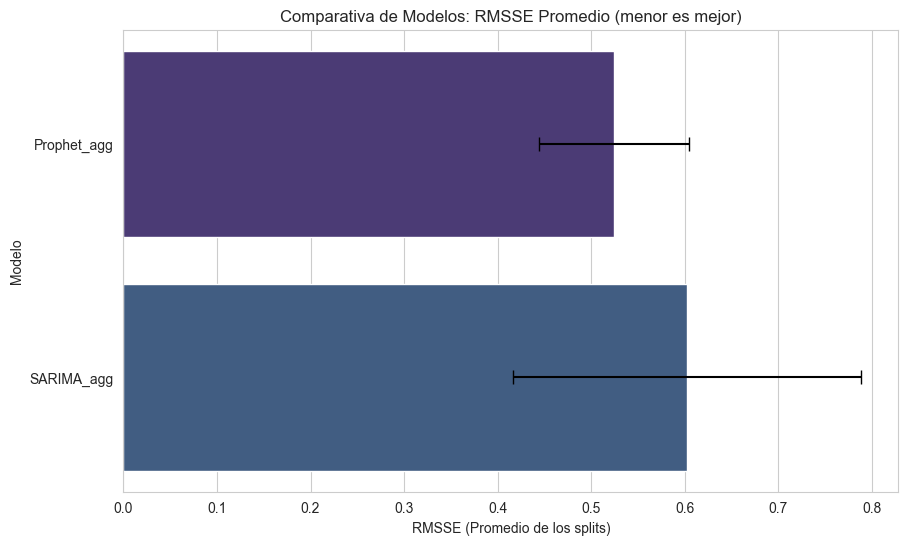

In [ ]:
resultados_lista = [result_naive, result_snaive, result_lr, result_lgbm, result_sarima, result_prophet]
df_resultados = pd.concat(resultados_lista, ignore_index=True)

leaderboard = df_resultados.groupby("modelo").agg({
    "RMSSE": ["mean", "std"],
    "RMSE": ["mean", "std"],
    "MAE": ["mean", "std"]
}).reset_index()

leaderboard.columns = ['Modelo', 'RMSSE_Mean', 'RMSSE_SD', 'RMSE_Mean', 'RMSE_SD', 'MAE_Mean', 'MAE_SD']

leaderboard = leaderboard.sort_values("RMSSE_Mean", ascending=True)

leaderboard["RMSSE Final"] = leaderboard.apply(lambda x: f"{x['RMSSE_Mean']:.4f} ± {x['RMSSE_SD']:.4f}", axis=1)
leaderboard["RMSE Final"] = leaderboard.apply(lambda x: f"{x['RMSE_Mean']:.4f} ± {x['RMSE_SD']:.4f}", axis=1)

print("=== LEADERBOARD DE MODELOS (Walk-Forward Validation) ===")
display(leaderboard[['Modelo', 'RMSSE Final', 'RMSE Final', 'MAE_Mean']])

In [ ]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x="RMSSE_Mean", 
    y="Modelo", 
    data=leaderboard, 
    palette="viridis", 
    hue="Modelo", 
    legend=False
)

plt.errorbar(
    x=leaderboard['RMSSE_Mean'], 
    y=range(len(leaderboard)), 
    xerr=leaderboard['RMSSE_SD'], 
    fmt='none',   
    c='black',    
    capsize=5      
)

plt.title("Comparativa de Modelos: RMSSE Promedio (menor es mejor)")
plt.xlabel("RMSSE (Promedio de los splits)")
plt.show()

## Análisis de Residuales

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\3238498969.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  id_dificil = df_val_plot.groupby('id')['error_abs'].mean().idxmax()


--- Visualizando Caso Típico: HOUSEHOLD_1_115_CA_1_validation ---


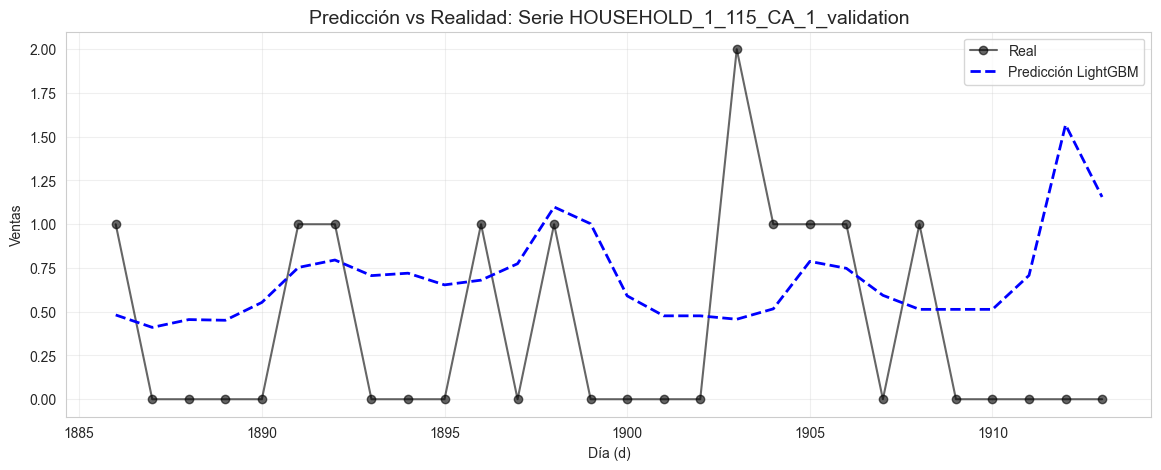

--- Visualizando Caso Difícil (Alta variabilidad/Error): FOODS_2_360_WI_2_validation ---


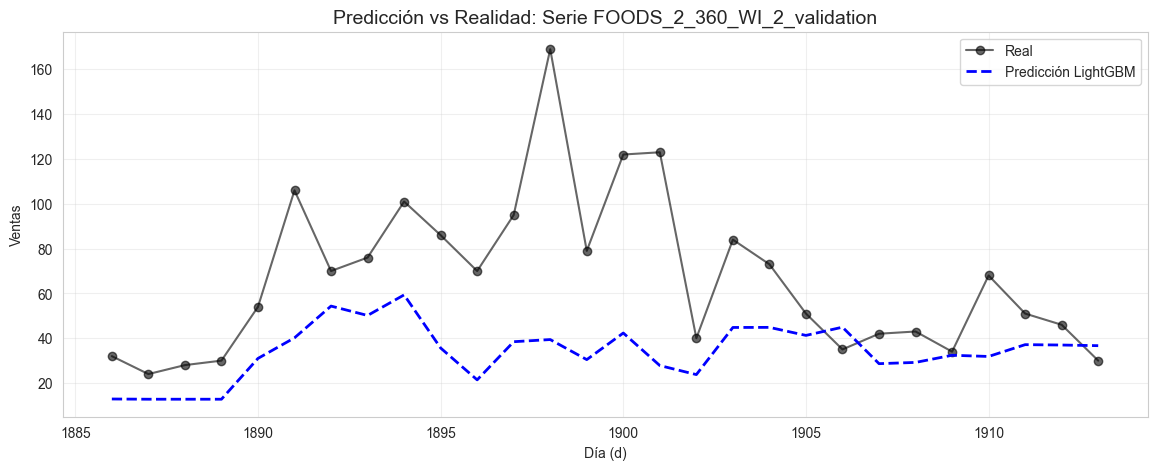

In [ ]:
train_days_last, val_days_last = splits[-1]
df_val_plot = df_val_lgbm.copy()

median_error = df_val_plot['error_abs'].median()
id_tipico = df_val_plot.iloc[(df_val_plot['error_abs'] - median_error).abs().argsort()[:1]]['id'].values[0]

id_dificil = df_val_plot.groupby('id')['error_abs'].mean().idxmax()

In [ ]:
def plot_serie_prediction(df_val, serie_id, model_name="LightGBM"):
    subset = df_val[df_val['id'] == serie_id].sort_values('d')
    
    plt.figure(figsize=(14, 5))
    plt.plot(subset['d'], subset['ventas'], label='Real', marker='o', color='black', alpha=0.6)
    plt.plot(subset['d'], subset['y_pred_lgbm'], label=f'Predicción {model_name}', color='blue', linestyle='--', linewidth=2)
    
    plt.title(f"Predicción vs Realidad: Serie {serie_id}", fontsize=14)
    plt.xlabel("Día (d)")
    plt.ylabel("Ventas")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print(f"--- Visualizando Caso Típico: {id_tipico} ---")
plot_serie_prediction(df_val_plot, id_tipico)

print(f"--- Visualizando Caso Difícil (Alta variabilidad/Error): {id_dificil} ---")
plot_serie_prediction(df_val_plot, id_dificil)

**Predicción y Residuales**

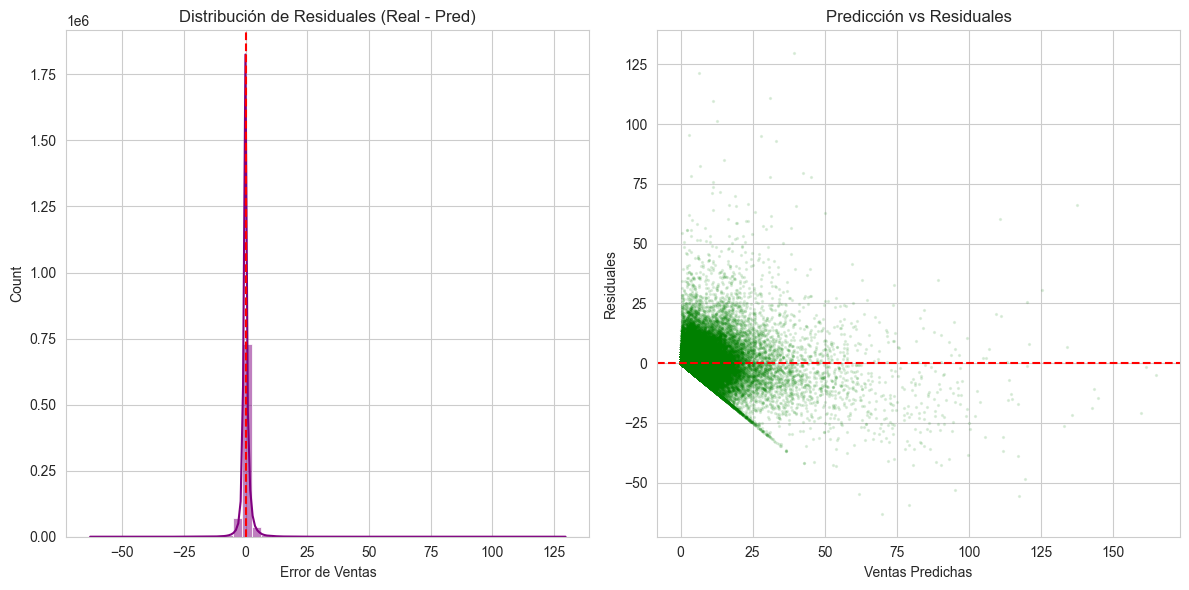

Media de residuales: -0.0331 (Cercano a 0 implica bajo sesgo global)
Skew de residuales: 4.6145


In [ ]:
residuals = df_val_plot['ventas'] - df_val_plot['y_pred_lgbm']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.title("Distribución de Residuales (Real - Pred)")
plt.xlabel("Error de Ventas")
plt.axvline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(df_val_plot['y_pred_lgbm'], residuals, alpha=0.1, color="green", s=2)
plt.title("Predicción vs Residuales")
plt.xlabel("Ventas Predichas")
plt.ylabel("Residuales")
plt.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

print(f"Media de residuales: {residuals.mean():.4f} (Cercano a 0 implica bajo sesgo global)")
print(f"Skew de residuales: {residuals.skew():.4f}")

---
## Análisis de Error por Subgrupos

C:\Users\diego\AppData\Local\Temp\ipykernel_10104\778664420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_cat.index, y=error_cat.values, ax=axes[0], palette="Blues_d")
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\778664420.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_state.index, y=error_state.values, ax=axes[1], palette="Greens_d")
C:\Users\diego\AppData\Local\Temp\ipykernel_10104\778664420.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_store.index, y=error_store.values, ax=axes[2], palette="

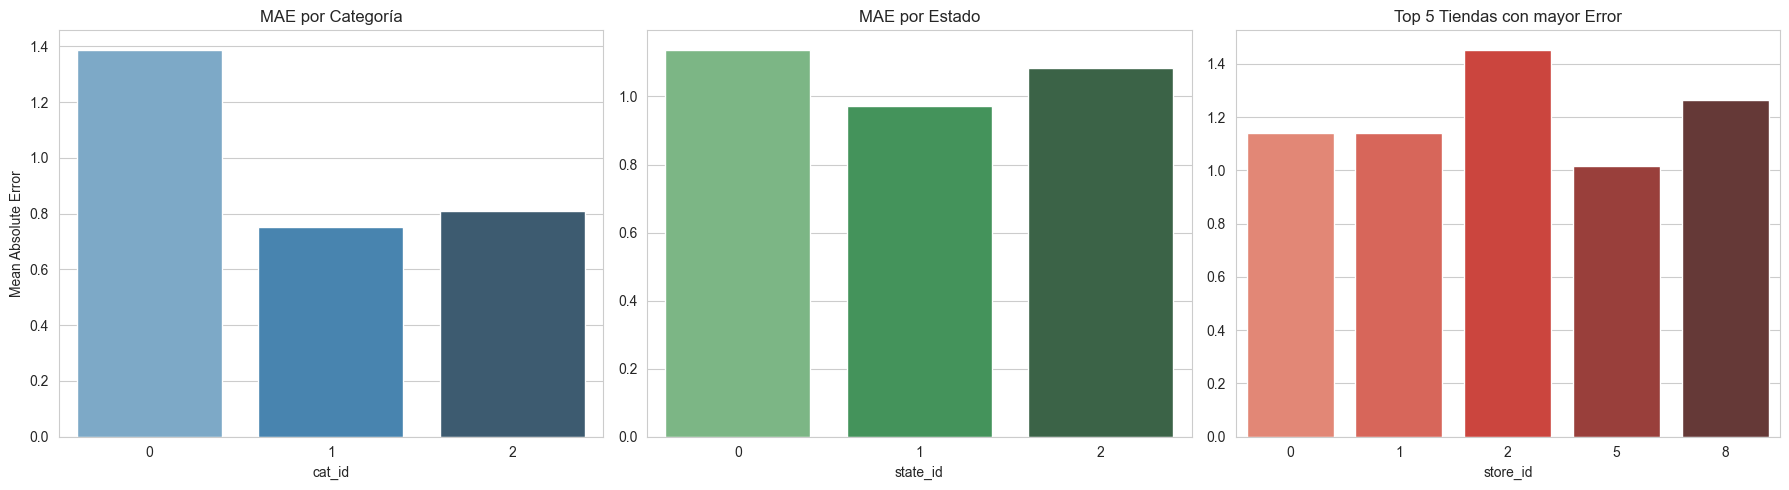

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

if 'cat_id' in df_val_plot.columns:
    error_cat = df_val_plot.groupby('cat_id')['error_abs'].mean().sort_values()
    sns.barplot(x=error_cat.index, y=error_cat.values, ax=axes[0], palette="Blues_d")
    axes[0].set_title("MAE por Categoría")
    axes[0].set_ylabel("Mean Absolute Error")

if 'state_id' in df_val_plot.columns:
    error_state = df_val_plot.groupby('state_id')['error_abs'].mean().sort_values()
    sns.barplot(x=error_state.index, y=error_state.values, ax=axes[1], palette="Greens_d")
    axes[1].set_title("MAE por Estado")

if 'store_id' in df_val_plot.columns:
    error_store = df_val_plot.groupby('store_id')['error_abs'].mean().sort_values(ascending=False).head(5)
    sns.barplot(x=error_store.index, y=error_store.values, ax=axes[2], palette="Reds_d")
    axes[2].set_title("Top 5 Tiendas con mayor Error")

plt.tight_layout()
plt.show()

---
## Estudio de Ablación (Ablation Study)

In [ ]:
def ablation_test(feature_to_drop, base_model_score):
    feats_ablation = [f for f in feature_cols if f != feature_to_drop]
    
    model_ablation = lgb.LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=123,
        verbose=-1
    )
    
    model_ablation.fit(X_train_lgbm[feats_ablation], y_train_lgbm)

    y_pred_abl = model_ablation.predict(X_val_lgbm[feats_ablation])
    
    score_abl = rmse(y_val_lgbm, y_pred_abl)
    
    impact = ((score_abl - base_model_score) / base_model_score) * 100
    return score_abl, impact

base_rmse = rmse(y_val_lgbm, model_lgbm_final.predict(X_val_lgbm))

print(f"RMSE Modelo Completo (Base): {base_rmse:.4f}\n")
print("--- Resultados de Ablación ---")

rmse_no_price, impact_price = ablation_test('sell_price', base_rmse)
print(f"Sin 'sell_price': RMSE = {rmse_no_price:.4f} | Deterioro: +{impact_price:.2f}%")

if 'snap' in feature_cols:
    rmse_no_snap, impact_snap = ablation_test('snap', base_rmse)
    print(f"Sin 'snap':       RMSE = {rmse_no_snap:.4f} | Deterioro: +{impact_snap:.2f}%")

rmse_no_lag, impact_lag = ablation_test('lag_28', base_rmse)
print(f"Sin 'lag_28':     RMSE = {rmse_no_lag:.4f} | Deterioro: +{impact_lag:.2f}%")

RMSE Modelo Completo (Base): 2.1745

--- Resultados de Ablación ---
Sin 'sell_price': RMSE = 2.1870 | Deterioro: +0.58%
Sin 'snap':       RMSE = 2.1860 | Deterioro: +0.53%
Sin 'lag_28':     RMSE = 2.1900 | Deterioro: +0.71%


---
---
# Interpretabilidad y análisis de error

## Cálculo de valores SHAP

In [ ]:
sample_idx = np.random.choice(X_val_lgbm.index, size=5000, replace=False)
X_shap = X_val_lgbm.loc[sample_idx]

explainer = shap.TreeExplainer(model_lgbm_final)
shap_values = explainer.shap_values(X_shap)

print("Cálculo de SHAP completado.")

Cálculo de SHAP completado.


## Resumen de Impacto Global (Beeswarm Plot)

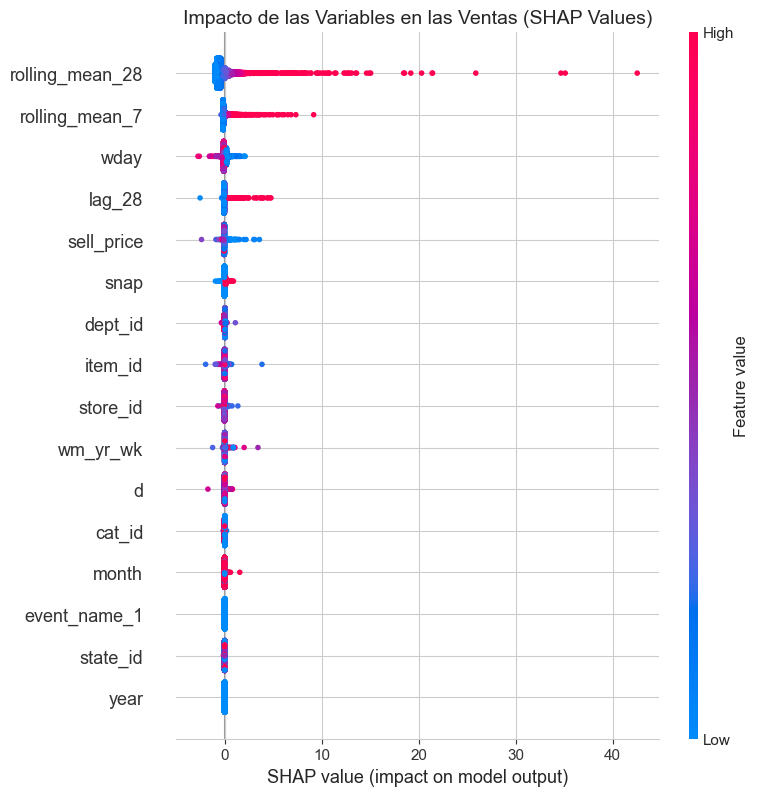

In [96]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("Impacto de las Variables en las Ventas (SHAP Values)", fontsize=14)
plt.show()

## Análisis de Dependencia: Elasticidad Precio

<Figure size 1200x700 with 0 Axes>

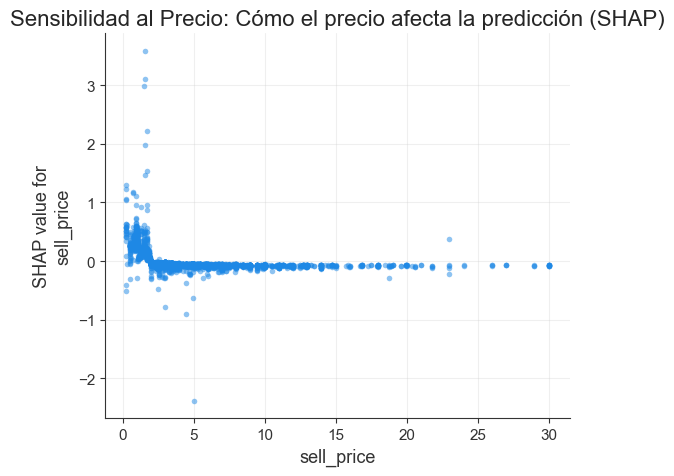

In [ ]:
vals_to_plot = shap_values
if isinstance(shap_values, list):
    vals_to_plot = shap_values[0]

plt.figure(figsize=(12, 7))

shap.dependence_plot(
    "sell_price", 
    vals_to_plot, 
    X_shap, 
    interaction_index=None,  
    alpha=0.5,
    show=False,              
    x_jitter=0.1             
)

plt.title("Sensibilidad al Precio: Cómo el precio afecta la predicción (SHAP)", fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

---
---
# Conclusiones técnicas

hemos desarrollado y evaluado un pipeline completo de pronóstico de demanda para el dataset M5 de Walmart, abarcando desde la limpieza de datos hasta la interpretación de modelos complejos. A continuación, presentamos las conclusiones principales y las recomendaciones estratégicas derivadas del estudio.


**Hallazgos Principales (Insights de Negocio)**

El análisis de interpretabilidad (SHAP) y el estudio de errores revelaron dinámicas clave del negocio. En primer lugar, la inercia demostró ser el predictor más fuerte; las variables de lags y promedios móviles (especialmente las ventanas de 7 y 28 días) dominaron la importancia del modelo, confirmando que el comportamiento reciente de ventas es el mejor estimador del futuro inmediato.

En segundo lugar, se confirmó una elasticidad precio clara, observándose una relación inversa entre el precio y el volumen de ventas, siendo esta sensibilidad mucho más aguda en la categoría FOODS que en HOBBIES. También se validó el efecto calendario, donde el día de la semana se consolidó como un determinante crítico con picos de demanda consistentes durante los fines de semana. Los eventos SNAP mostraron un impacto positivo focalizado en las tiendas de los estados correspondientes, validando la importancia de las variables regionales. Finalmente, el análisis por segmento mostró que el modelo tiene un desempeño sobresaliente en productos de alta rotación (Top Sellers), aunque el error porcentual tiende a aumentar en productos de la "cola larga" (baja rotación), donde la señal es más ruidosa.

**Comparación de Modelos**

Al contrastar las diferentes arquitecturas evaluadas, se observaron diferencias notables en rendimiento y escalabilidad. Los modelos base (Naive y SNaive) presentaron métricas de error altas y una alta variabilidad, demostrando ser útiles únicamente como puntos de referencia básicos, ya que no logran capturar tendencias complejas ni efectos exógenos. Por su parte, la Regresión Lineal ofreció un desempeño medio, viéndose limitada por su incapacidad para capturar no-linealidades sin una ingeniería de características excesivamente manual.

Los modelos de series de tiempo tradicionales (Prophet y SARIMA) resultaron efectivos para visualizar la tendencia de la serie agregada global, pero se volvieron computacionalmente inviables y menos precisos al intentar modelar las más de 30,000 series individuales. Finalmente, LightGBM se posicionó como el modelo ganador indiscutible, logrando el RMSSE promedio más bajo y una estabilidad superior entre los periodos de validación, ofreciendo el mejor balance entre precisión, velocidad de entrenamiento y capacidad de interpretación.

**Recomendaciones de Implementación**

Para el paso a producción de este sistema, recomendamos el despliegue del modelo LightGBM como el motor principal de inferencia debido a su robustez y eficiencia. Es crucial implementar un pipeline de re-entrenamiento periódico (idealmente mensual) para que el modelo pueda capturar cambios de tendencia recientes y adaptarse a la introducción de nuevos productos. Asimismo, se sugiere establecer un sistema de monitoreo de drifts para vigilar la distribución de las variables de entrada (como cambios bruscos de precios) y del target, permitiendo detectar tempranamente cualquier degradación en la calidad de las predicciones.


**Mejoras Futuras**

Para seguir mejorando la precisión, especialmente en los productos de baja rotación (long tail), sugerimos explorar modelos híbridos que combinen LightGBM para los top sellers con modelos estadísticos probabilísticos (como Croston o DeepAR) para los productos intermitentes. Otra vía de mejora es entrenar LightGBM optimizando directamente la función de pérdida Tweedie, la cual se adapta matemáticamente mejor a distribuciones de ventas con gran cantidad de ceros. Finalmente, la integración de variables exógenas adicionales, como datos de inventario (para distinguir una venta cero real de un quiebre de stock) y datos climáticos locales, podría refinar aún más la capacidad predictiva del sistema.